## DecMeg2014 - Decoding the Human Brain

### Documentación

Repositorio de Kaggle: 
 https://www.kaggle.com/c/decoding-the-human-brain

Repositorio de Github (Ejemplos de códigos en Matlab y Python):
https://github.com/FBK-NILab/DecMeg2014

### Importación de librerías

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.signal import decimate
from sklearn import metrics
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt

## Red LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


### Coger los datos de los archivos .mat

#### Preprocesamiento: Coger primeros 500ms de datos y normalizarlos

Creamos una función "create_features" que se encargará de devolver los valores X. En esta función, se realiza todo el procesamiento de los datos. Los preprocesamiento que realiza son:

    1. Paso de la lista X de 3D a 2D. Poniendo como filas el primer elemento (las diferentes pruebas) y como columnas se hace un join del segundo elemento(series temporales o canales) y del tercer elemento(valores de cada serie temporal)
    
    2. Cogemos una ventana de valores
    
    3. Normalizamos los valores restandolos por la media y dividiéndolo por la desviación típica

In [0]:
def create_features(XX, tmin, tmax, sfreq, tmin_original=-0.5, start=130, stop=375, downsample=8):
    """Creation of the feature space:
    - restricting the time window of MEG data to [tmin, tmax]sec.
    - Concatenating the 306 timeseries of each trial in one long
      vector.
    - Normalizing each feature independently (z-scoring).
    """
    # Decimate the time dimension (lowpass filtering + resampling)

    XX = decimate(XX, downsample)
    
    print("Applying the desired time window.")
    startIdx = int(start / float(downsample) + 0.5)
    stopIdx  = int(stop / float(downsample) + 0.5)
    XX = XX[..., startIdx:stopIdx]
    
    # Eliminamos los primero 180 senores que tienen mas correlacion
    XX = XX[:,180:, :]

    #print("2D Reshaping: concatenating all 306 timeseries.")
    #XX = XX.reshape(XX.shape[0], XX.shape[1] * XX.shape[2])

    print("Features Normalization.")
    XX -= XX.mean(0)
    XX = np.nan_to_num(XX / XX.std(0))

    return XX

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Coger todos los .mat en un array aplicando el preprocesado

Cogemos los datos de los ficheros train_subject13.mat, del 13 al 16. En esta etapa se realizan varios pasos:

    1. Creamos una lista X_train y y_train que contendrán todos los datos para realizar el entrenamiento. 
    
    2. Por cada uno de los ficheros, llamamos a la función create_features para que realice el correspondiente preprocesamiento de los datos.
    
    3. Una vez tenemos los datos del fichero, los agregamos a la lista.
    
    4. Una vez tenemos todas las listas en la lista, creamos un array realizando un join de las listas dentro de la lista. Para eso utilizamos la función vstack de la librería numpy

In [4]:
subjects_train = range(1, 17) # use range(13, 16) for all subjects
print("Training on subjects", subjects_train )

# We throw away all the MEG data outside the first 0.5sec from when
# the visual stimulus start:
tmin = 0.0
tmax = 0.500
print("Restricting MEG data to the interval [%s, %s]sec." % (tmin, tmax))

X_train = []
y_train = []
X_test = []
ids_test = []

print("Creating the trainset.")
for subject in subjects_train:
    filename = '/content/drive/My Drive/Maching Learning/Dataset/train_subject%02d.mat' % subject
    print("Loading", filename)
    data = loadmat(filename, squeeze_me=True)
    XX = data['X']
    yy = data['y']
    sfreq = data['sfreq']
    tmin_original = data['tmin']
    print("Dataset summary:")
    print("XX:", XX.shape)
    print("yy:", yy.shape)
    print("sfreq:", sfreq)

    XX = create_features(XX, tmin, tmax, sfreq)
    
    print("XX (Preprocessed): ", XX.shape)

    X_train.append(XX)
    y_train.append(yy)
    
X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)
print("Trainset:", X_train.shape)

Training on subjects range(1, 17)
Restricting MEG data to the interval [0.0, 0.5]sec.
Creating the trainset.
Loading /content/drive/My Drive/Maching Learning/Dataset/train_subject01.mat
Dataset summary:
XX: (594, 306, 375)
yy: (594,)
sfreq: 250.0
Applying the desired time window.
Features Normalization.
XX (Preprocessed):  (594, 126, 31)
Loading /content/drive/My Drive/Maching Learning/Dataset/train_subject02.mat
Dataset summary:
XX: (586, 306, 375)
yy: (586,)
sfreq: 250.0
Applying the desired time window.
Features Normalization.
XX (Preprocessed):  (586, 126, 31)
Loading /content/drive/My Drive/Maching Learning/Dataset/train_subject03.mat
Dataset summary:
XX: (578, 306, 375)
yy: (578,)
sfreq: 250.0
Applying the desired time window.
Features Normalization.
XX (Preprocessed):  (578, 126, 31)
Loading /content/drive/My Drive/Maching Learning/Dataset/train_subject04.mat
Dataset summary:
XX: (594, 306, 375)
yy: (594,)
sfreq: 250.0
Applying the desired time window.
Features Normalization.
XX

### Visualización de datos

#### Prueba 1 de todos los sensores

306


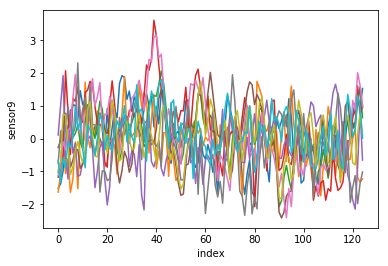

In [0]:
df_sensores = pd.DataFrame()
print(len(X_train[0,:]))
for i in range(0,len(X_train[0,:])):
    nameSensor = 'sensor%s' % i
    df_sensores[nameSensor] = pd.Series(X_train[0,i,:])

df_sensores["index"] = pd.Series(range(0,125))
for i in range(0, 10):
    nameSensor = "sensor%s" % i
    sns.lineplot(x="index", y=nameSensor, data=df_sensores)

plt.show()

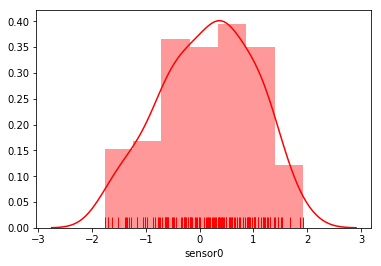

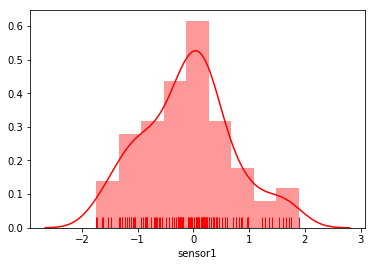

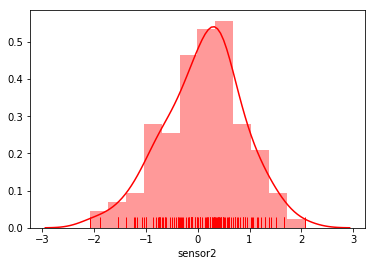

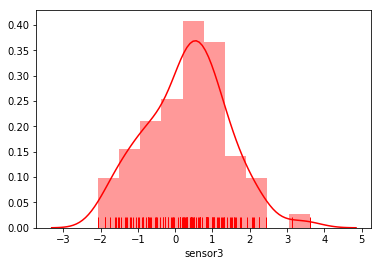

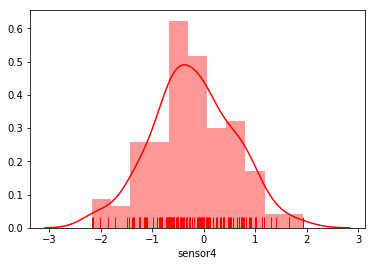

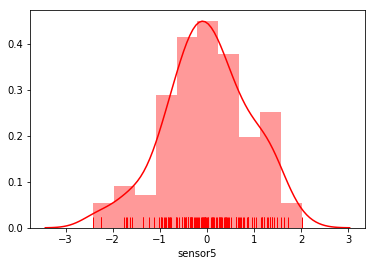

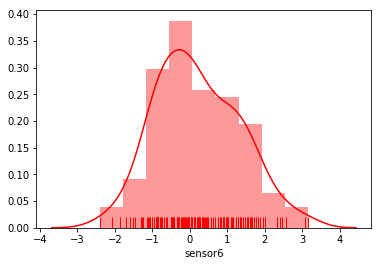

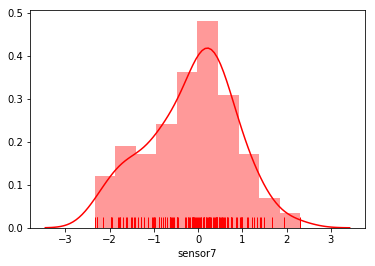

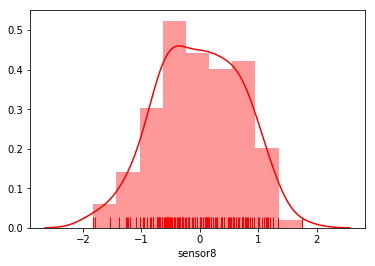

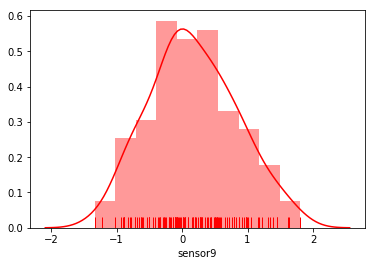

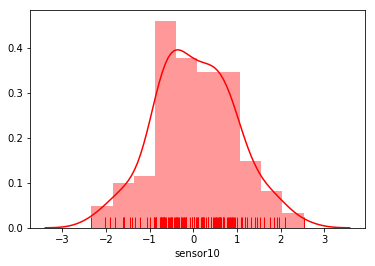

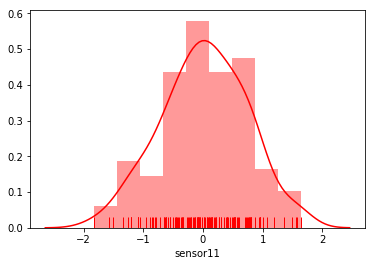

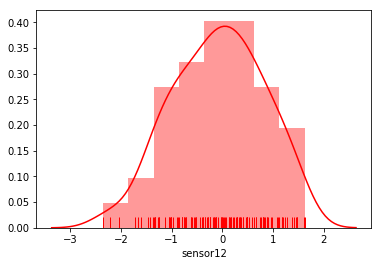

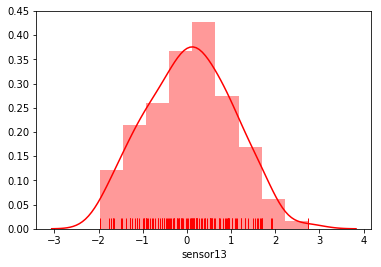

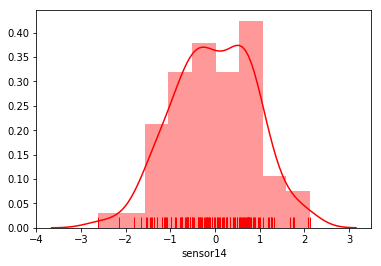

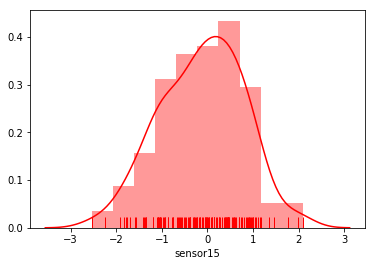

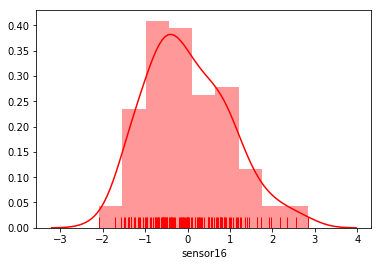

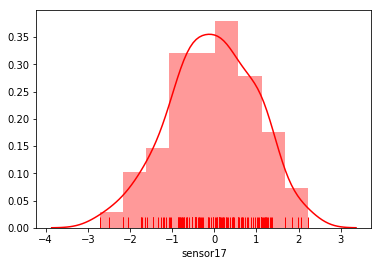

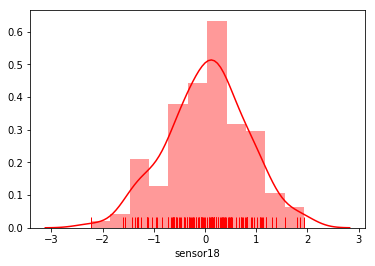

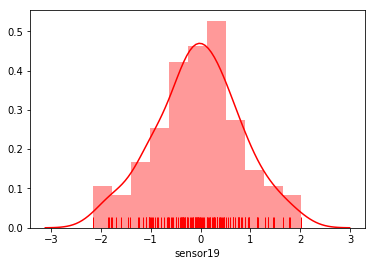

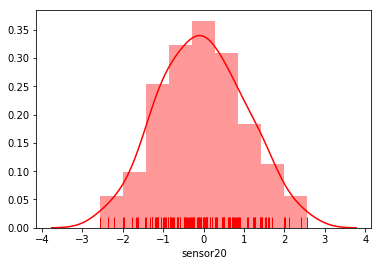

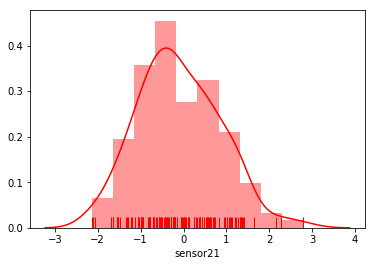

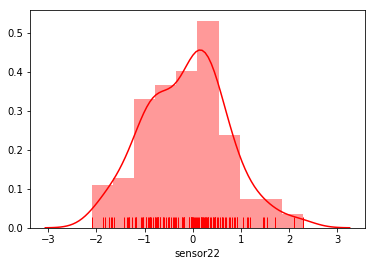

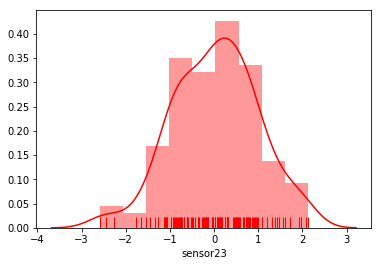

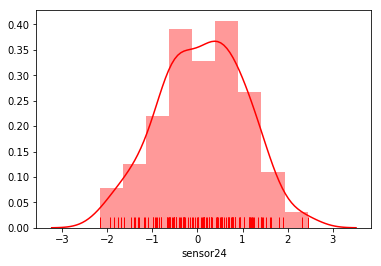

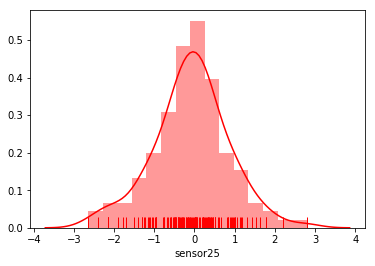

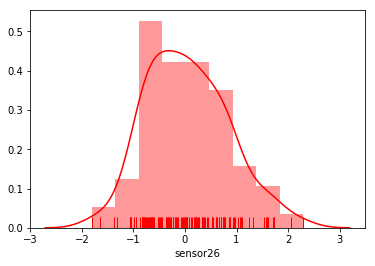

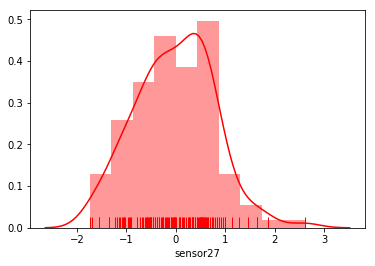

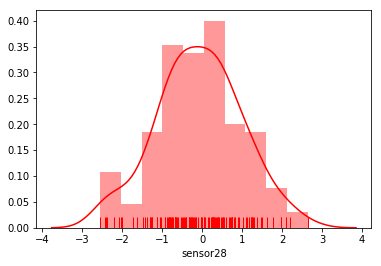

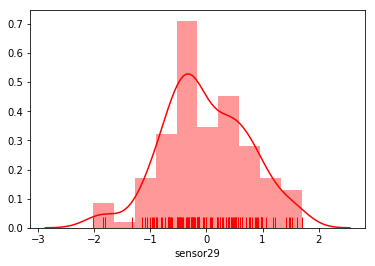

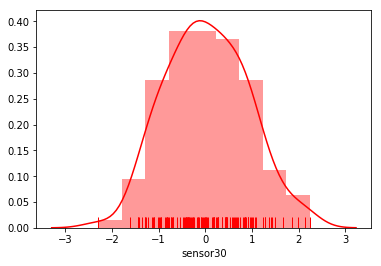

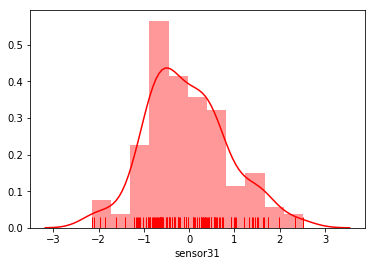

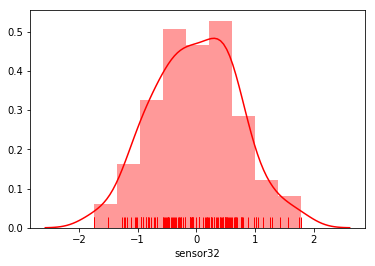

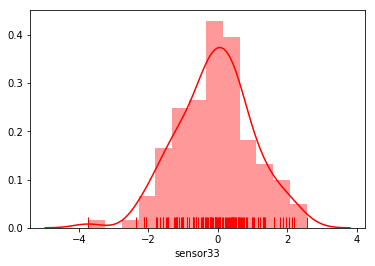

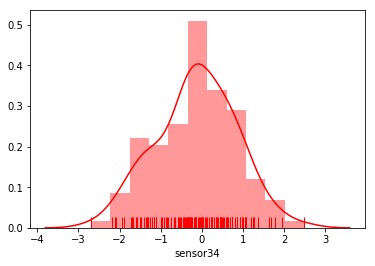

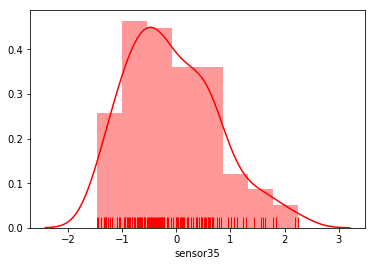

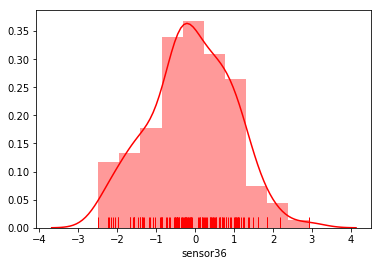

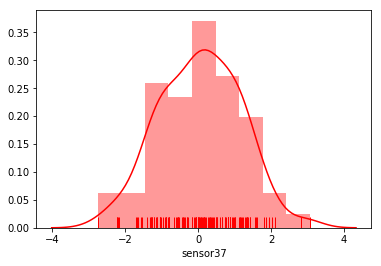

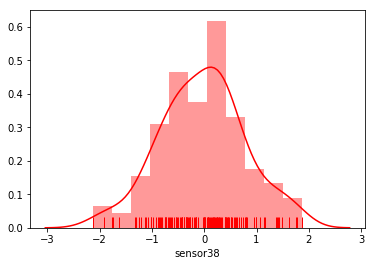

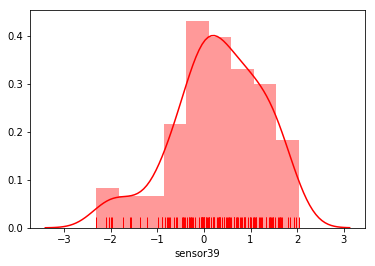

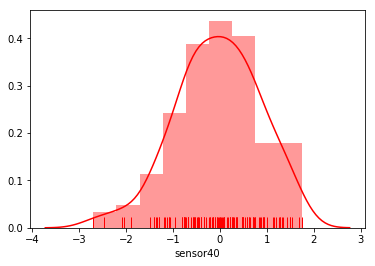

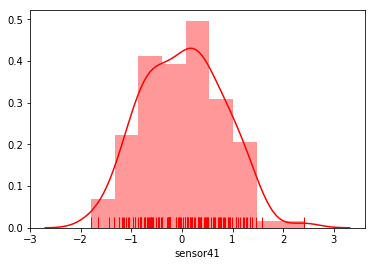

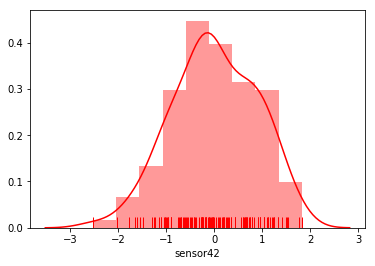

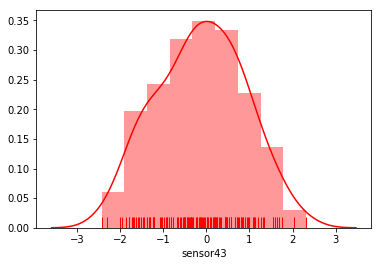

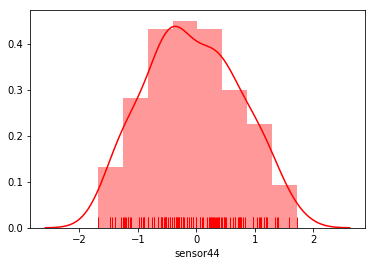

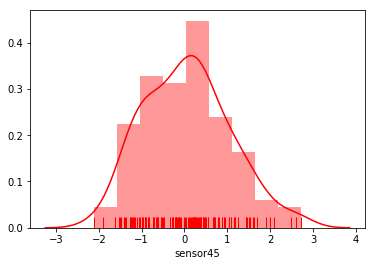

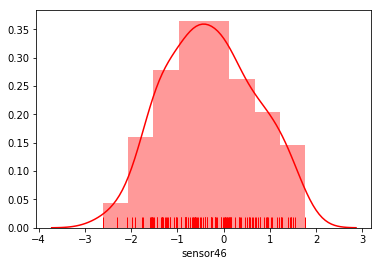

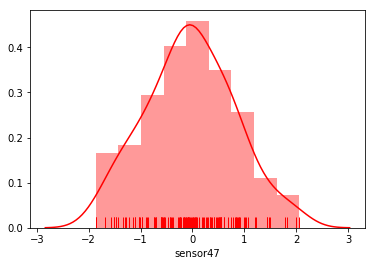

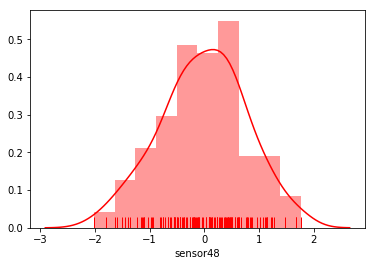

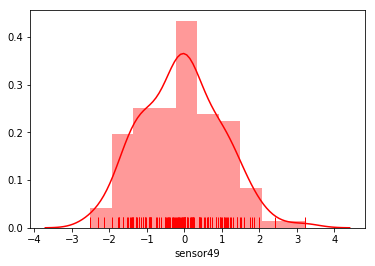

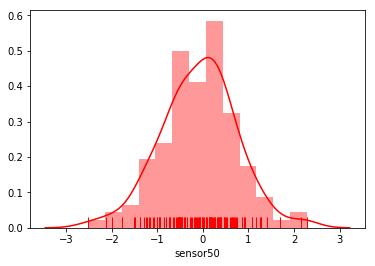

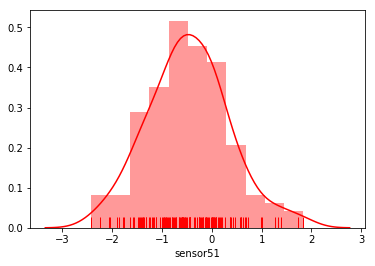

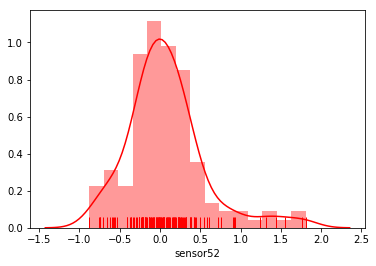

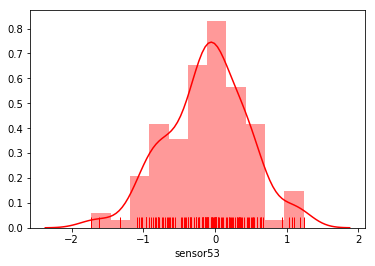

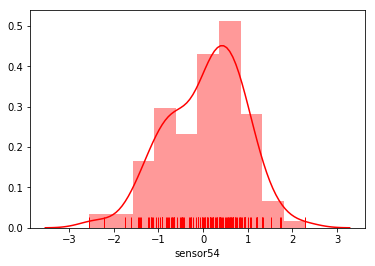

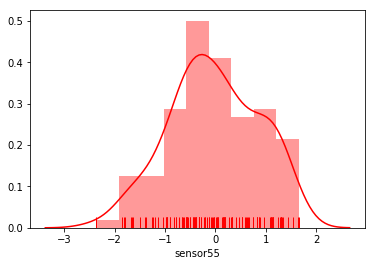

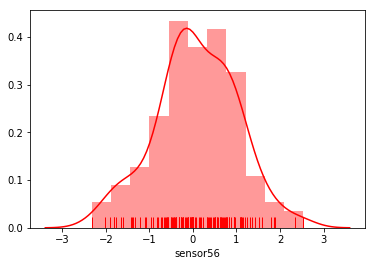

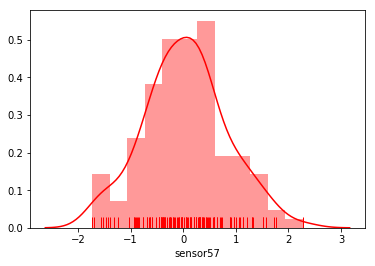

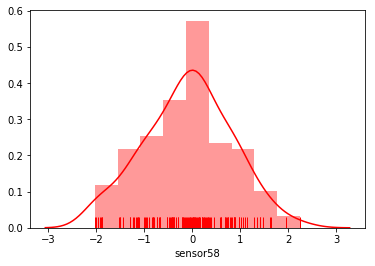

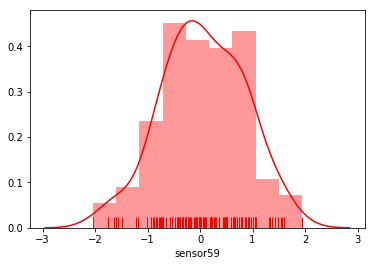

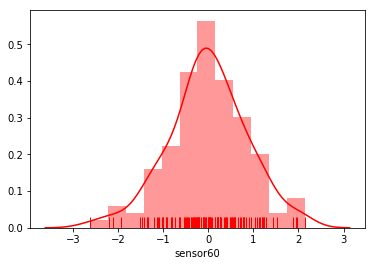

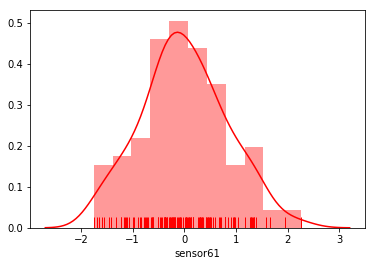

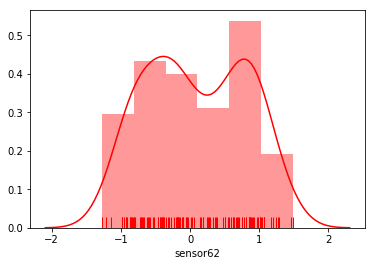

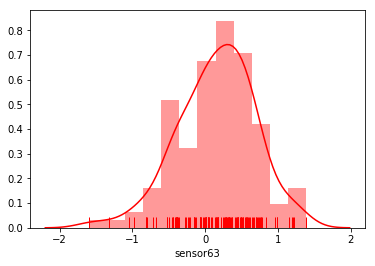

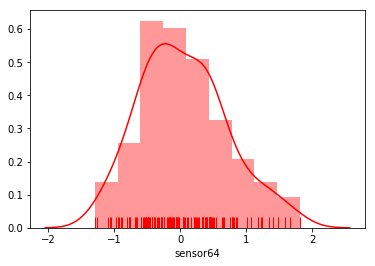

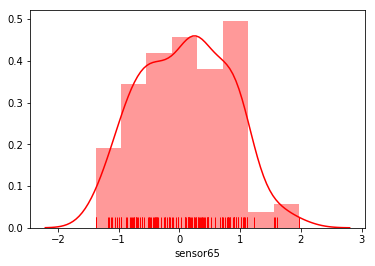

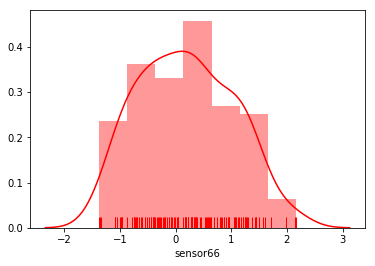

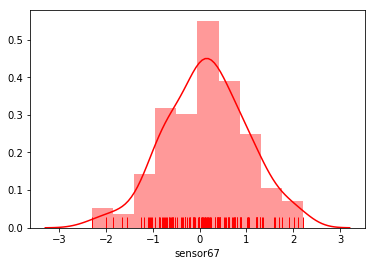

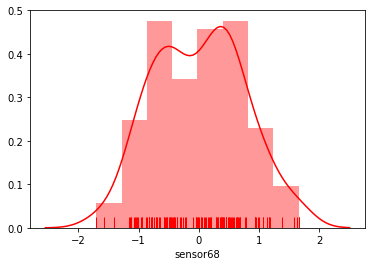

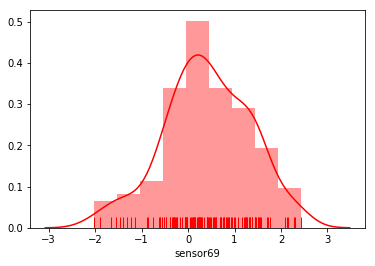

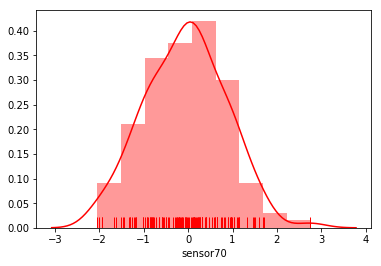

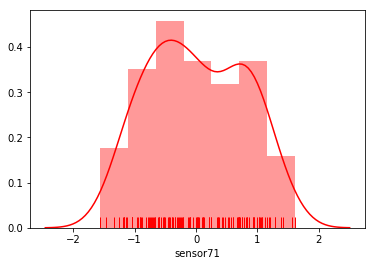

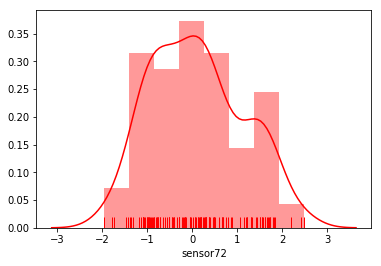

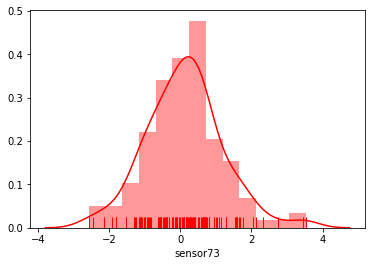

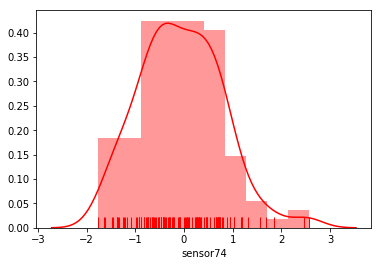

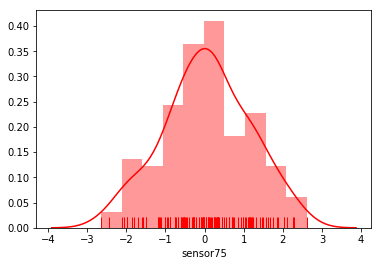

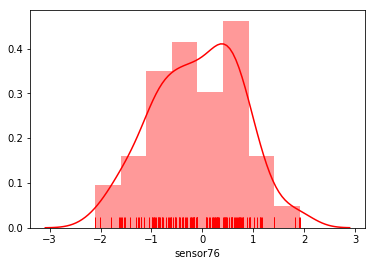

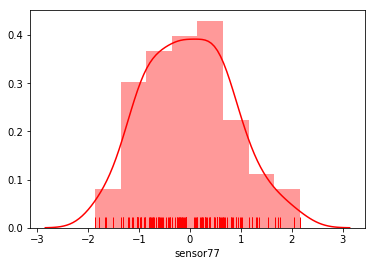

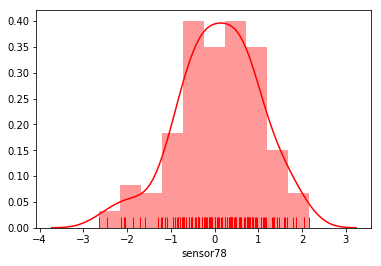

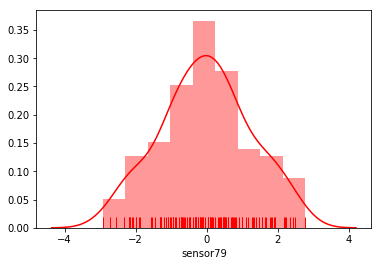

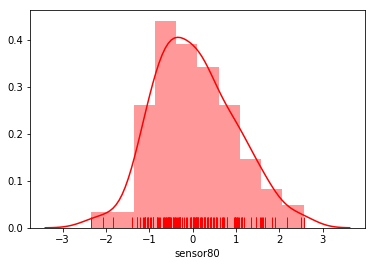

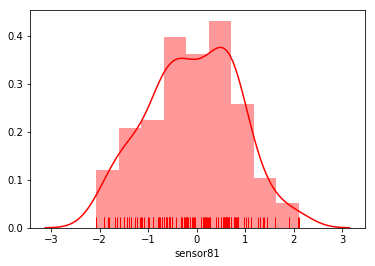

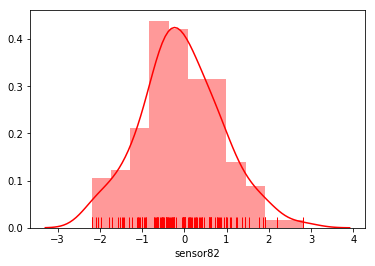

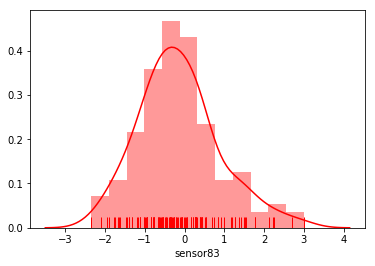

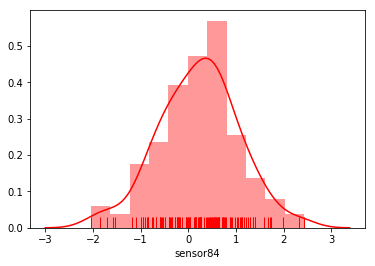

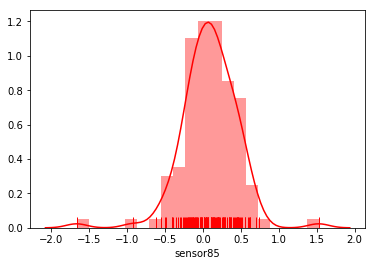

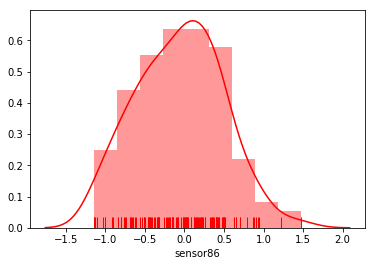

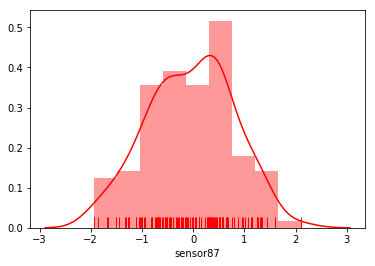

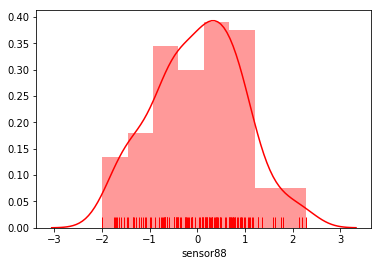

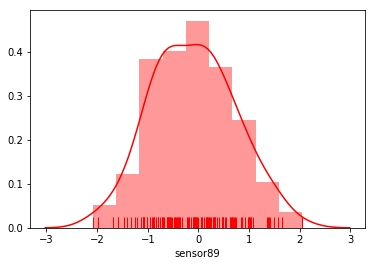

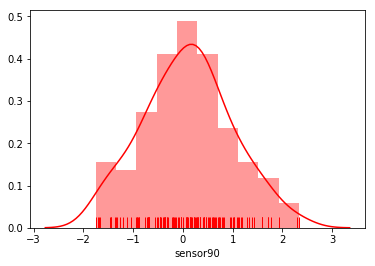

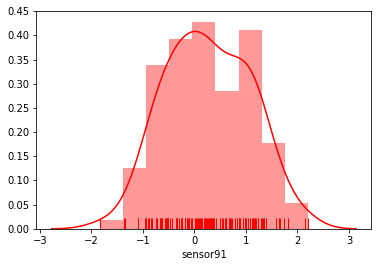

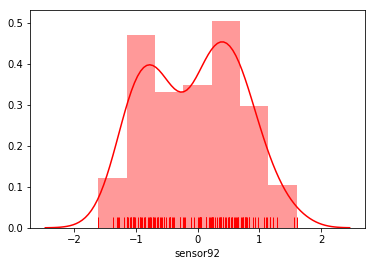

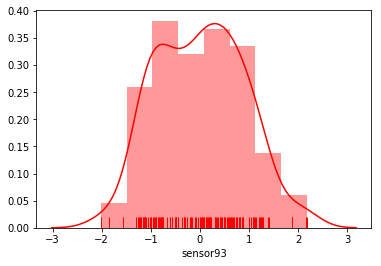

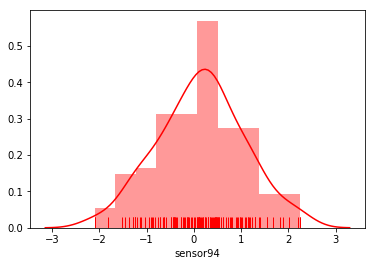

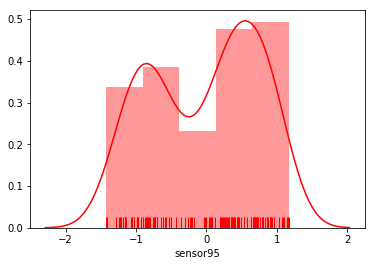

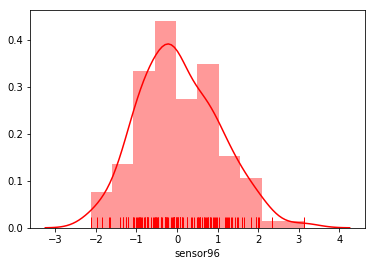

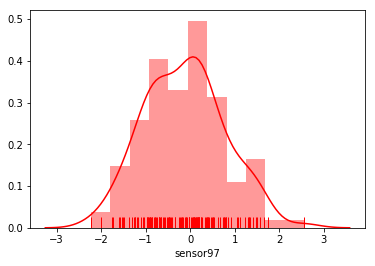

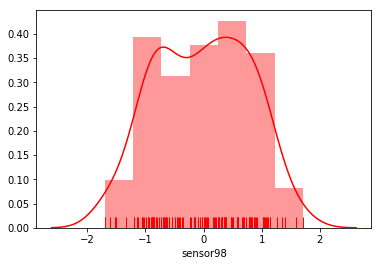

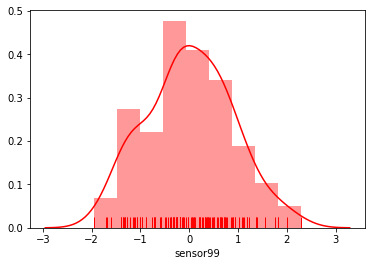

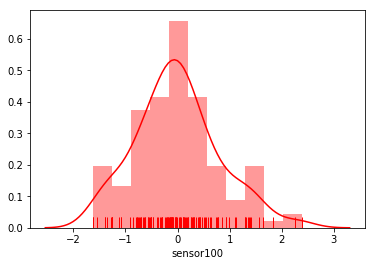

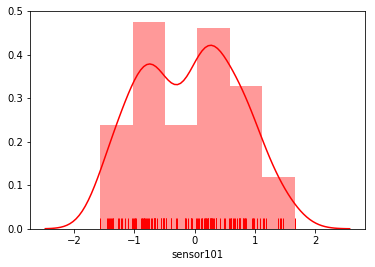

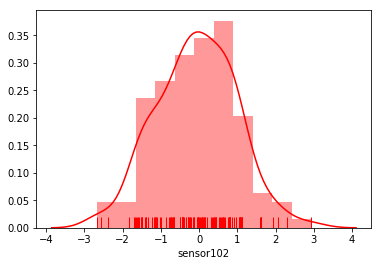

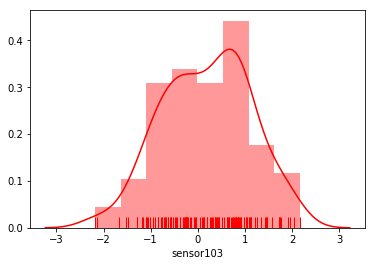

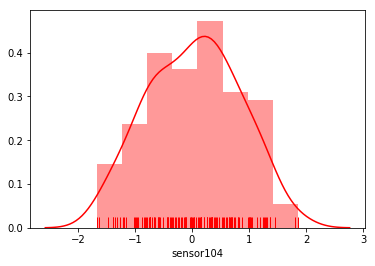

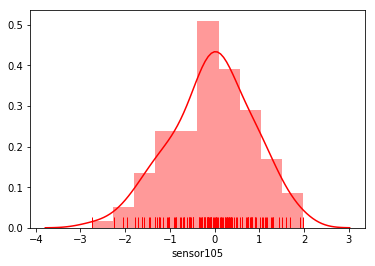

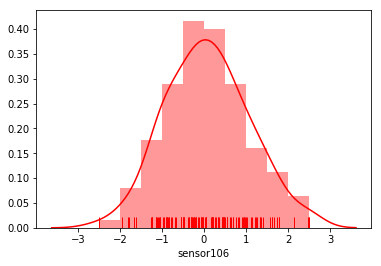

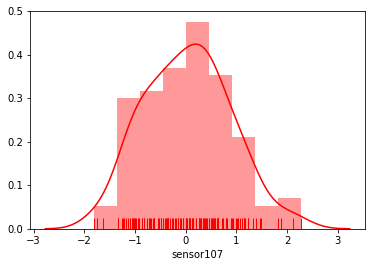

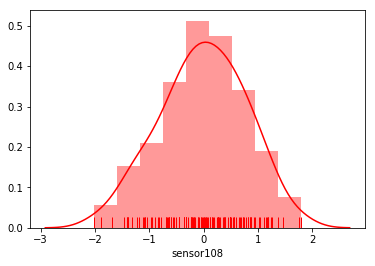

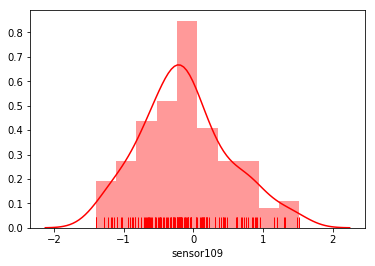

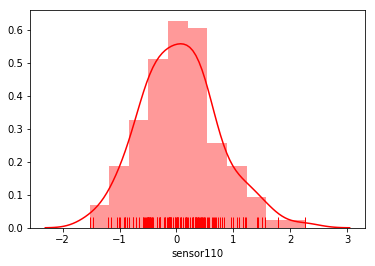

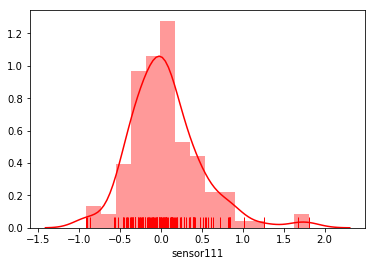

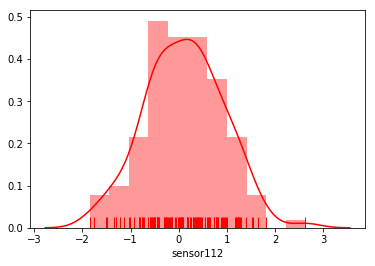

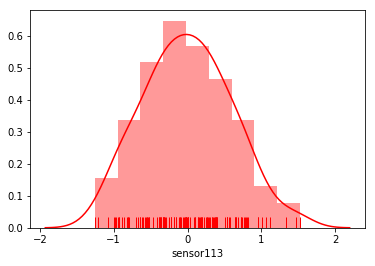

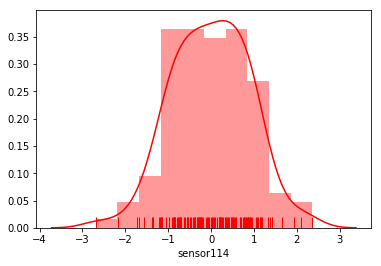

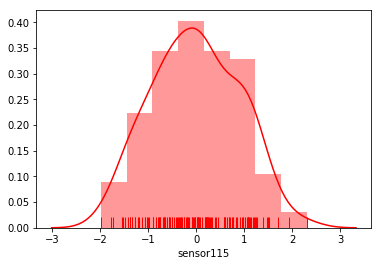

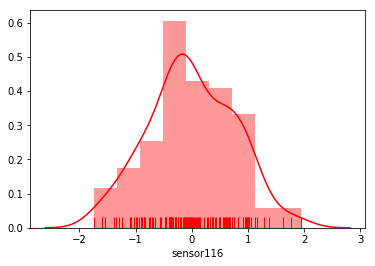

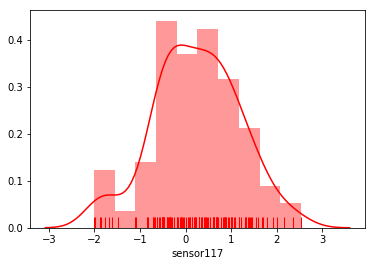

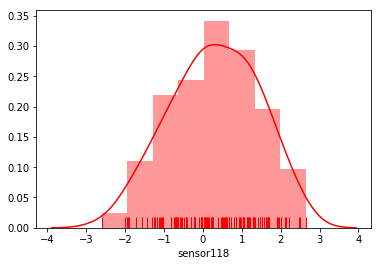

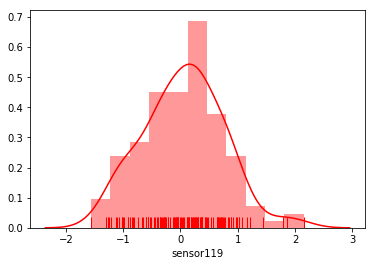

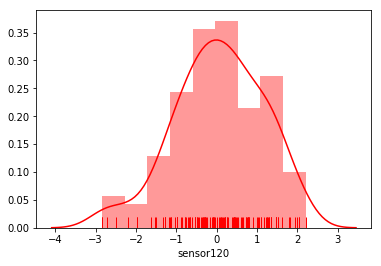

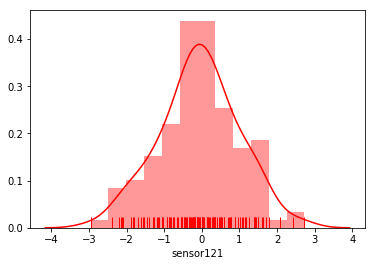

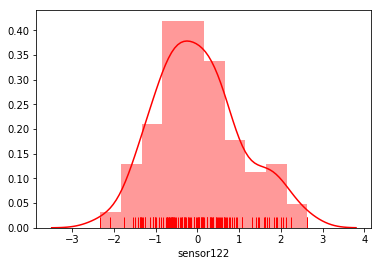

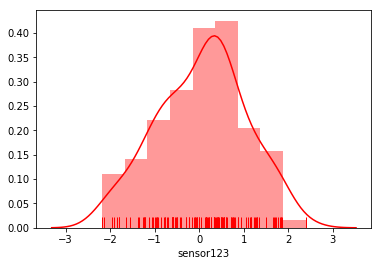

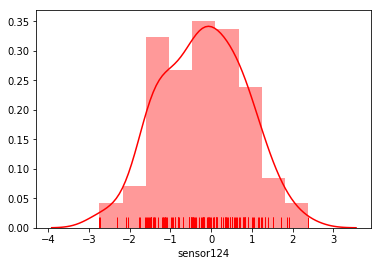

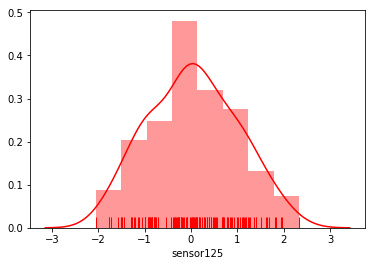

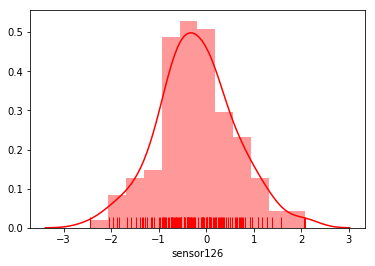

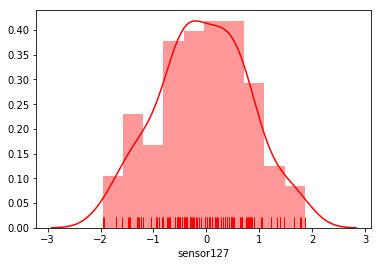

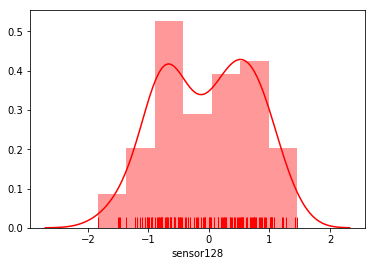

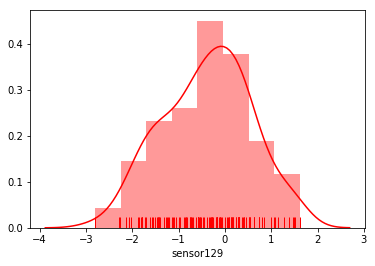

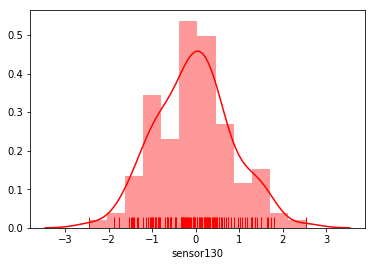

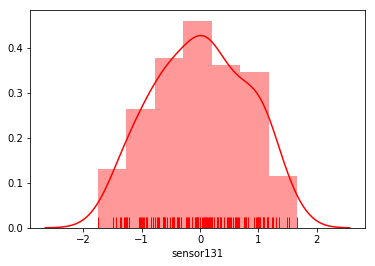

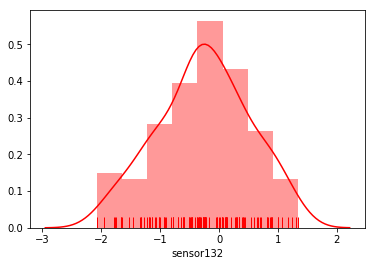

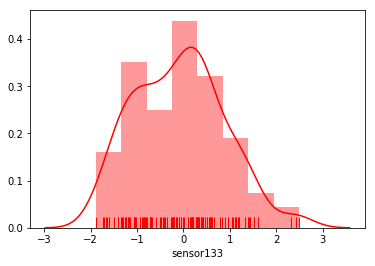

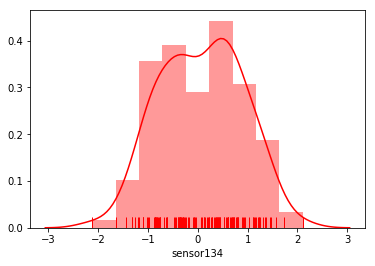

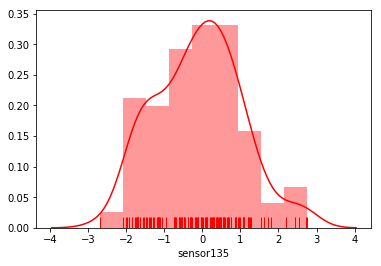

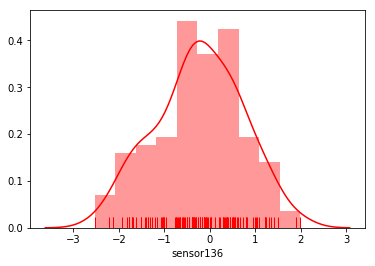

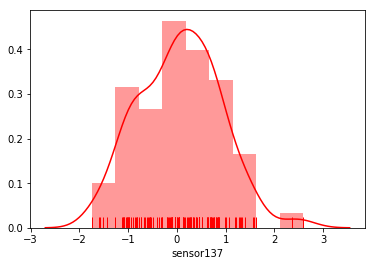

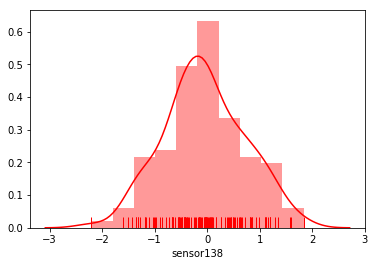

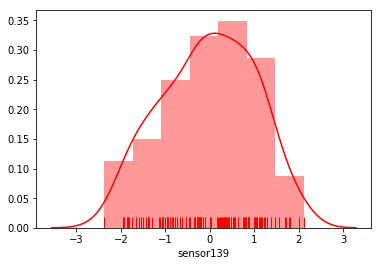

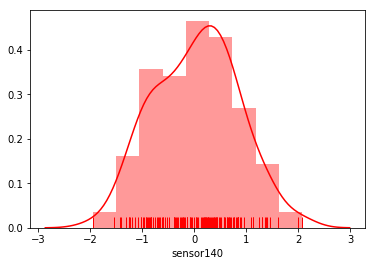

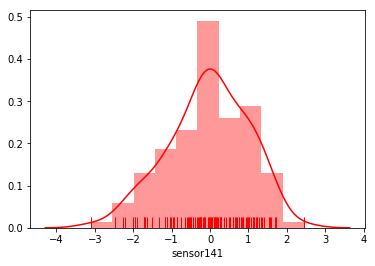

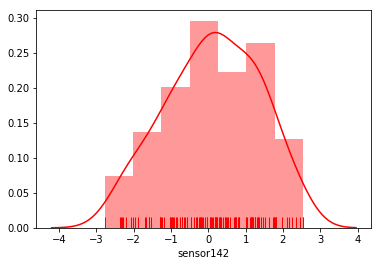

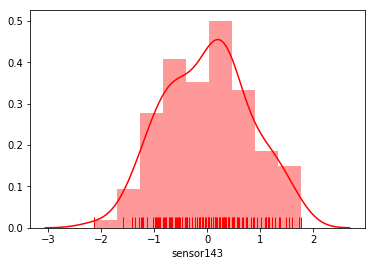

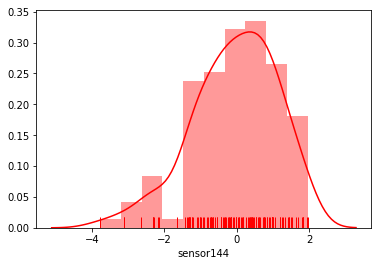

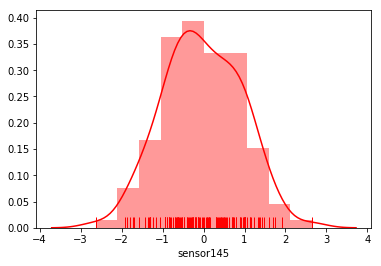

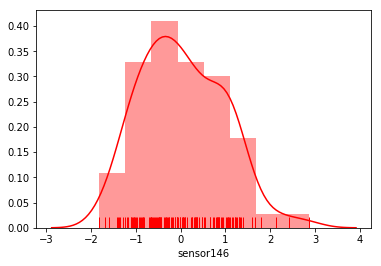

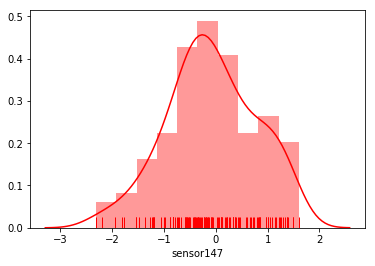

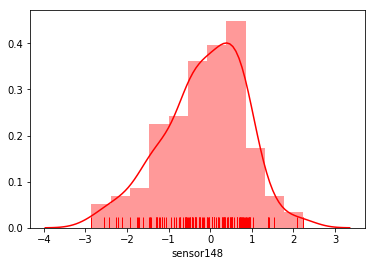

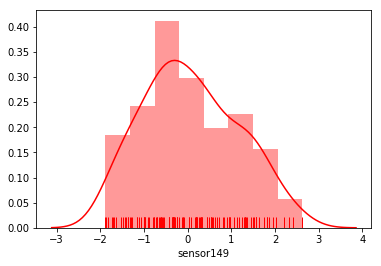

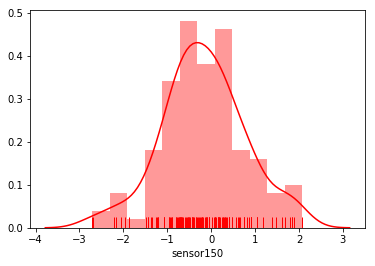

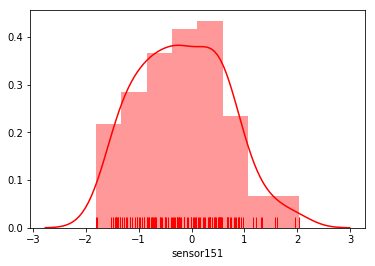

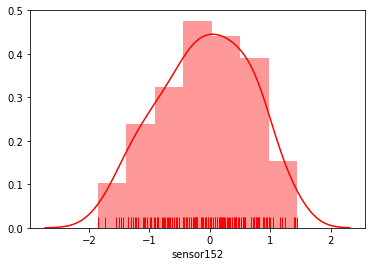

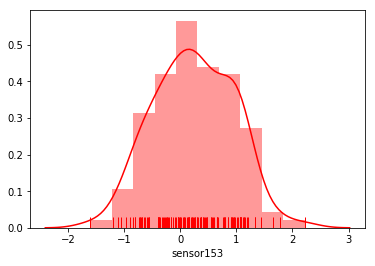

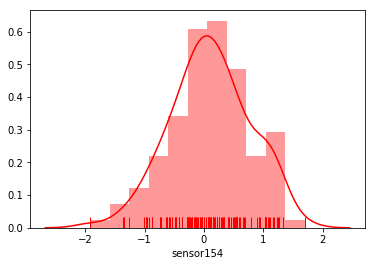

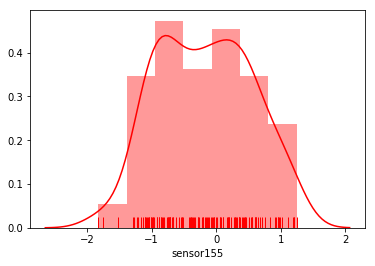

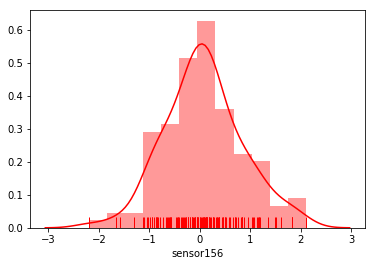

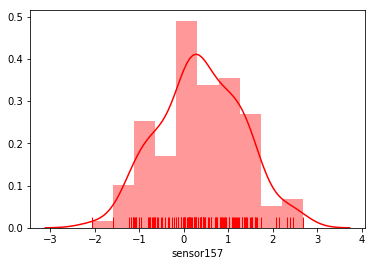

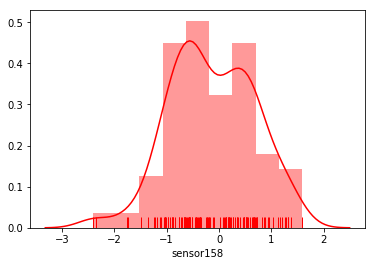

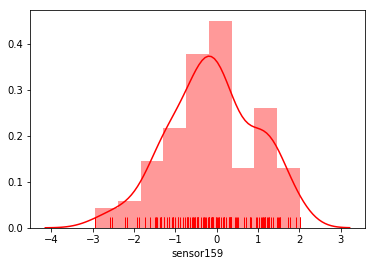

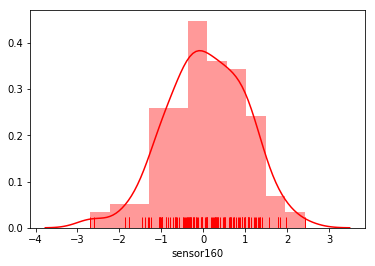

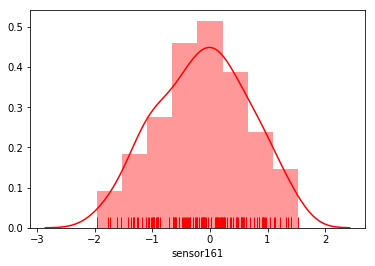

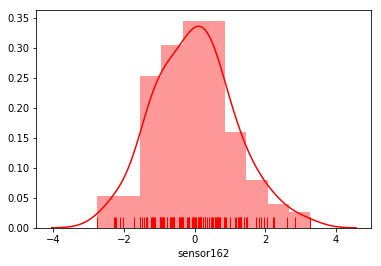

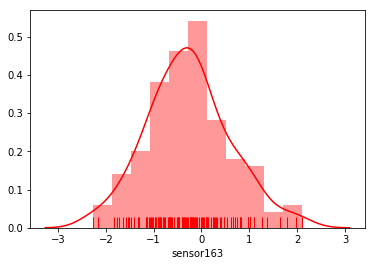

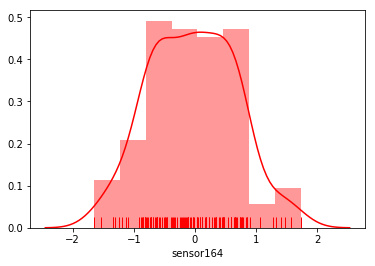

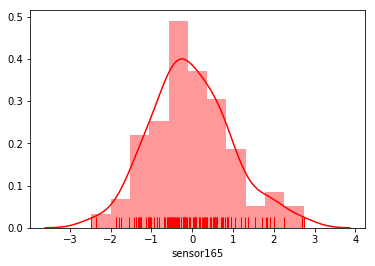

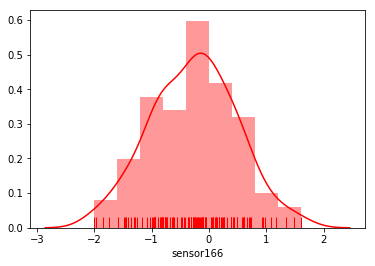

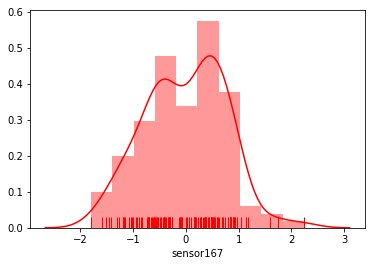

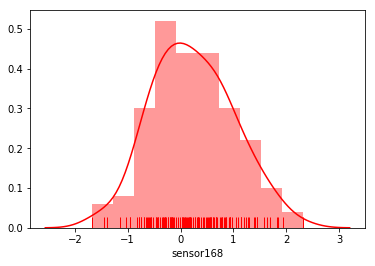

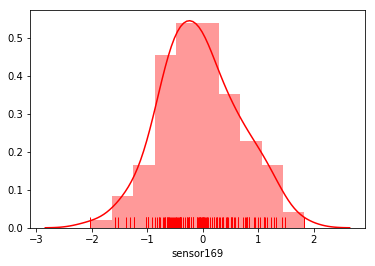

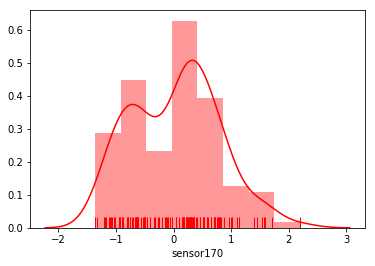

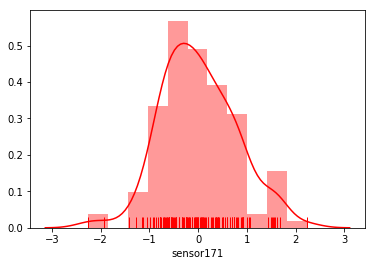

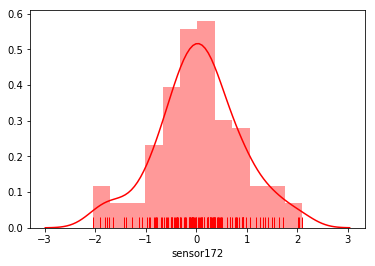

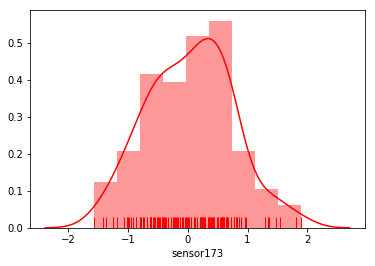

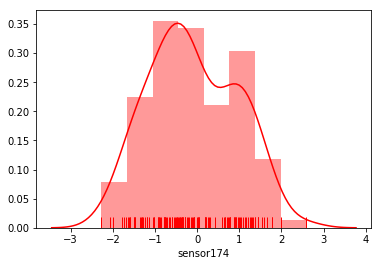

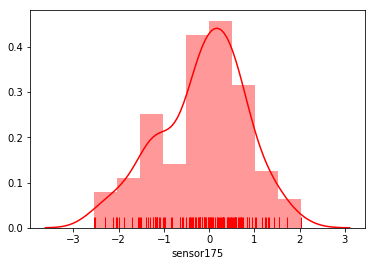

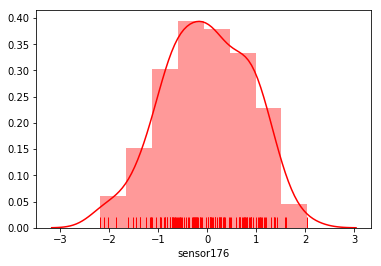

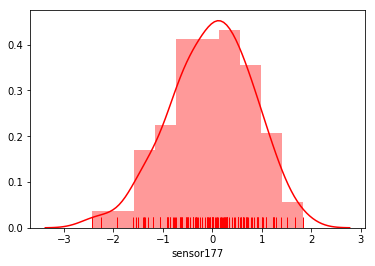

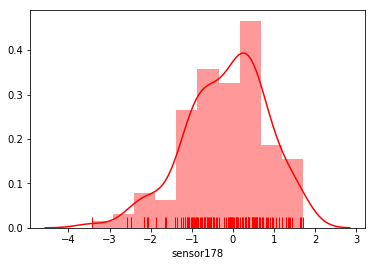

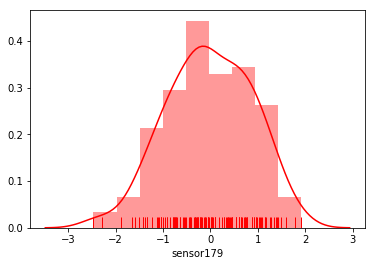

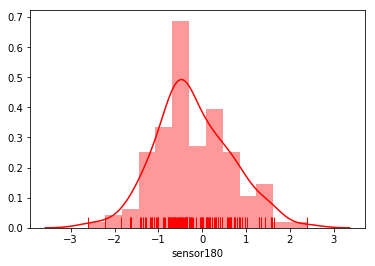

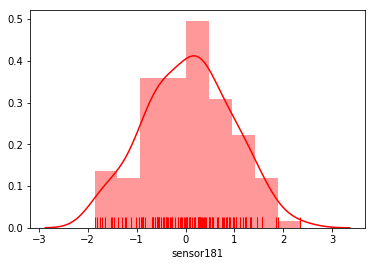

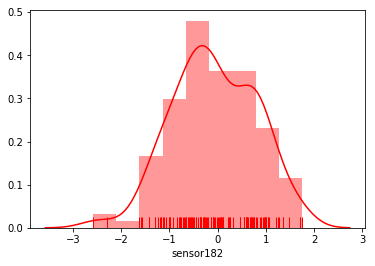

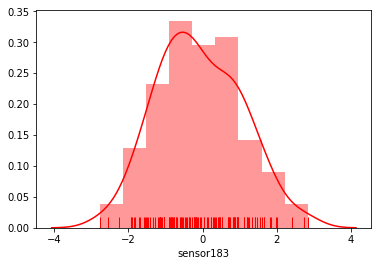

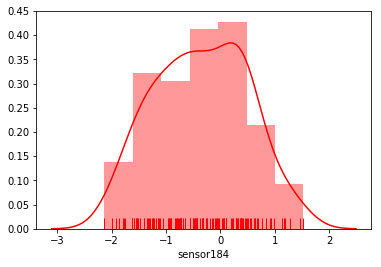

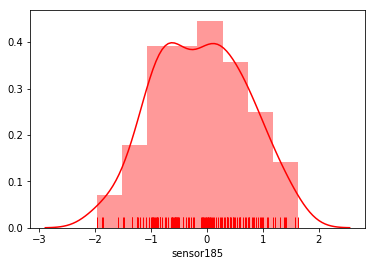

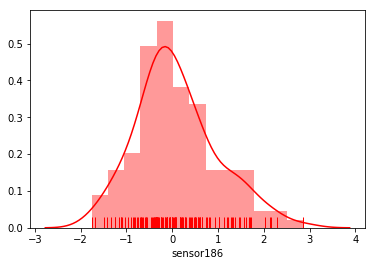

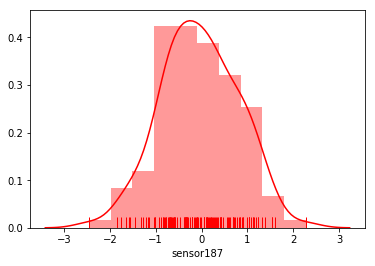

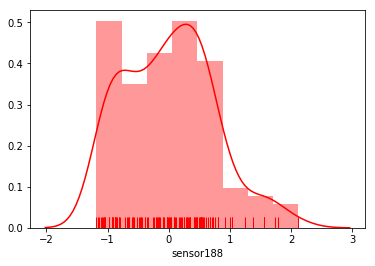

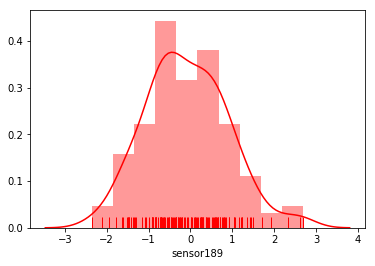

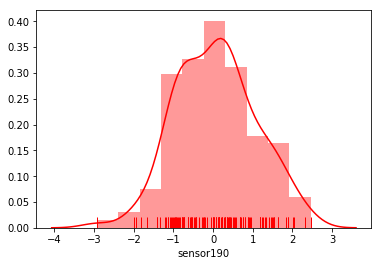

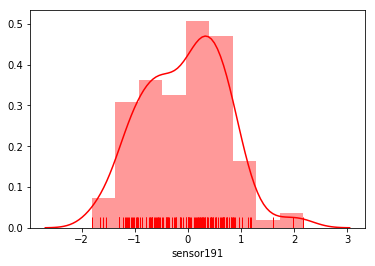

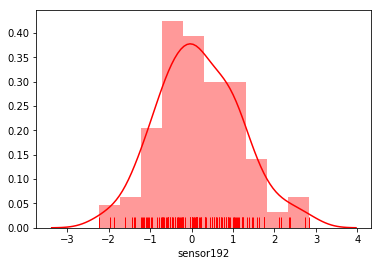

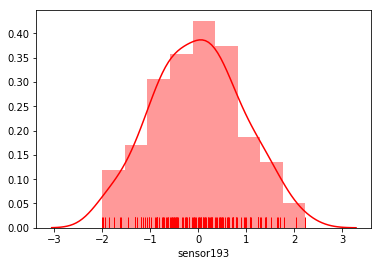

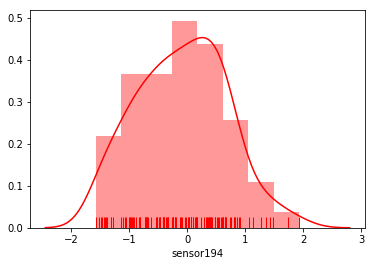

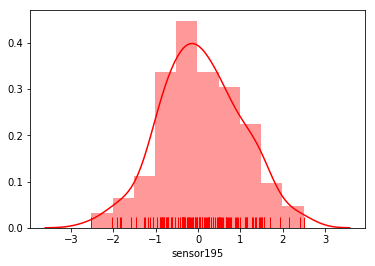

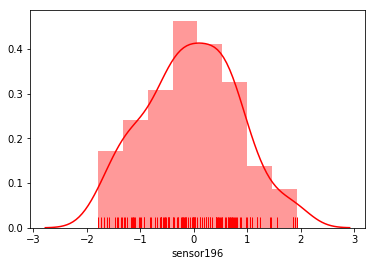

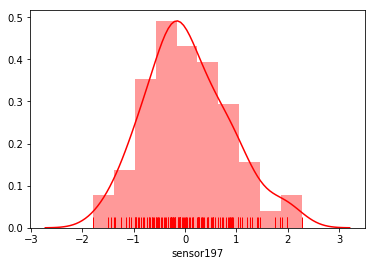

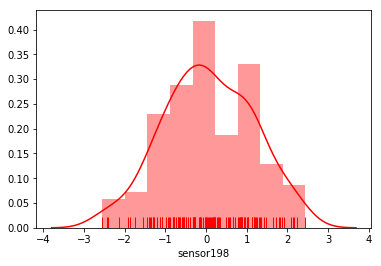

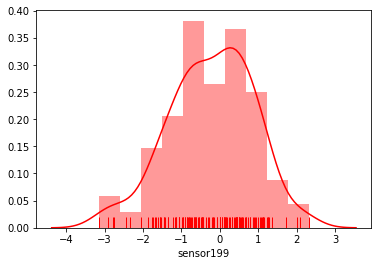

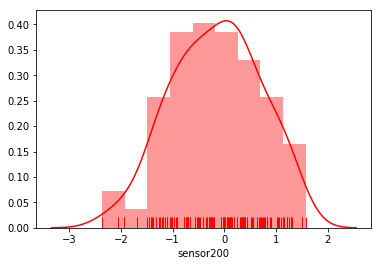

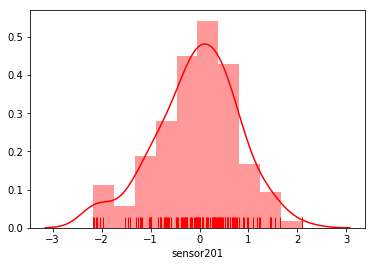

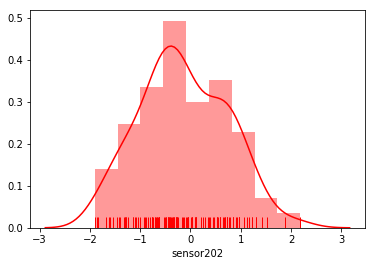

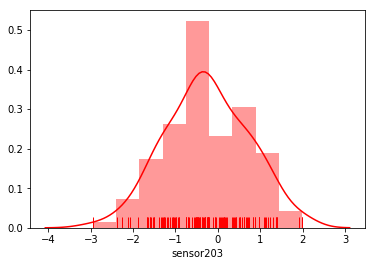

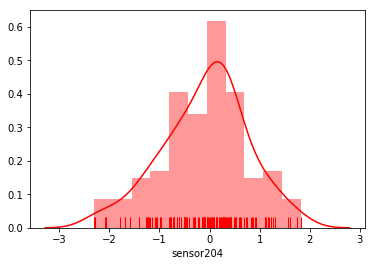

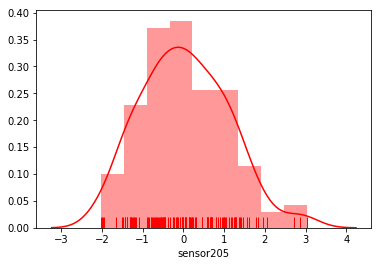

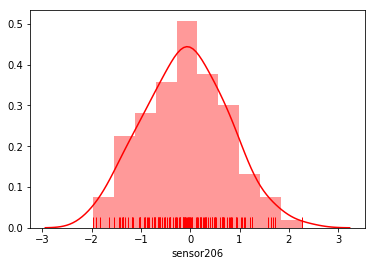

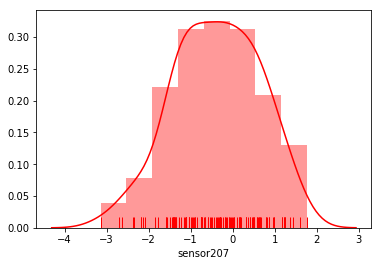

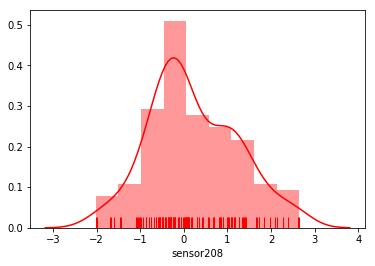

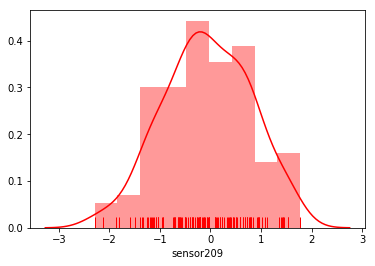

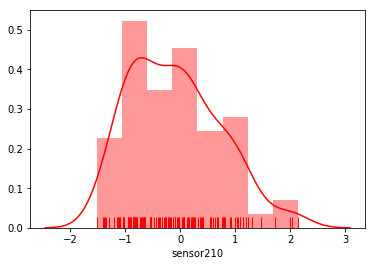

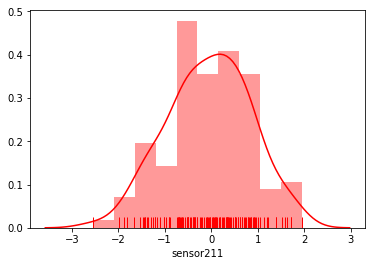

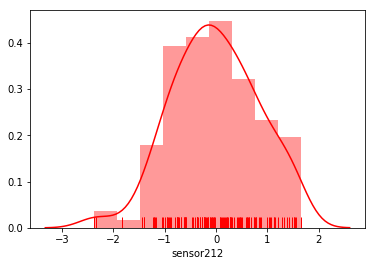

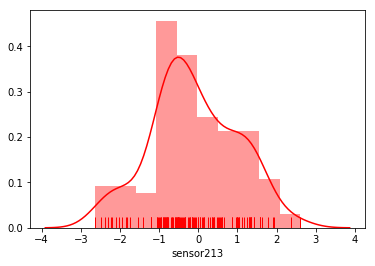

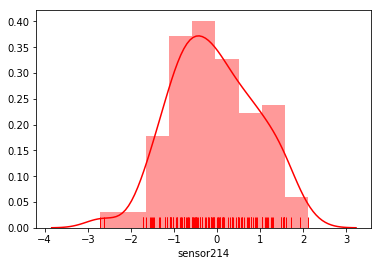

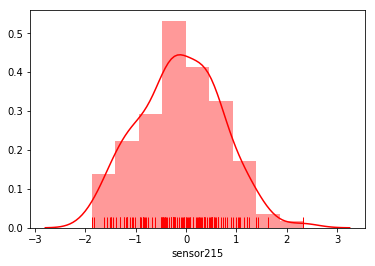

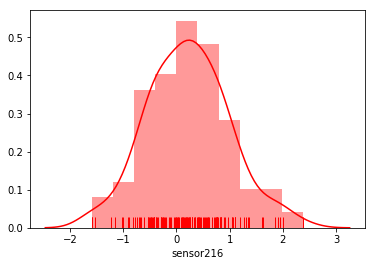

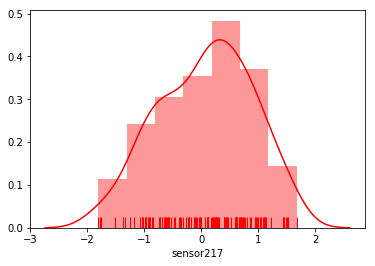

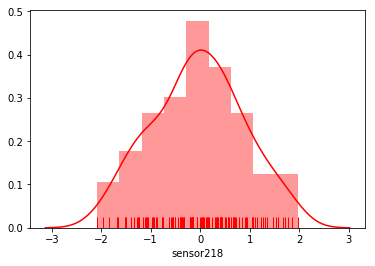

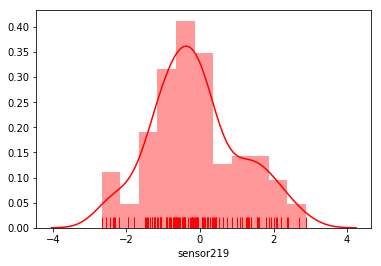

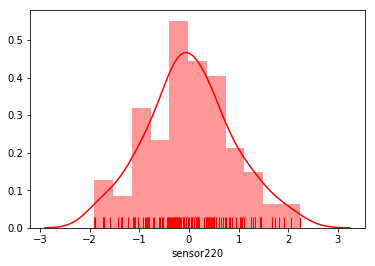

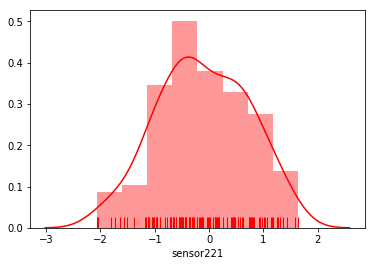

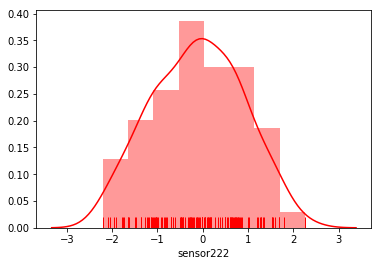

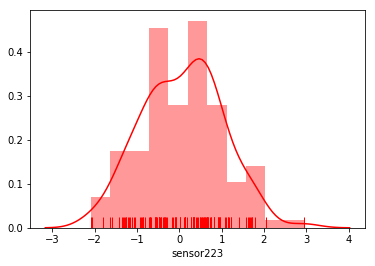

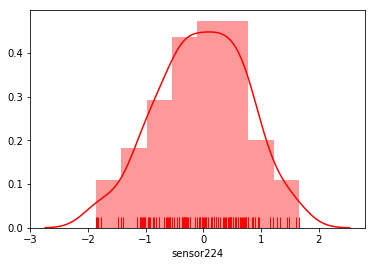

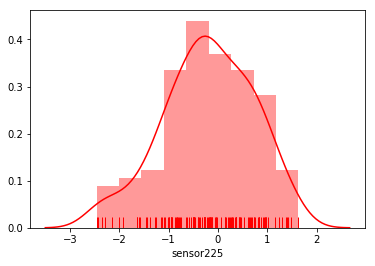

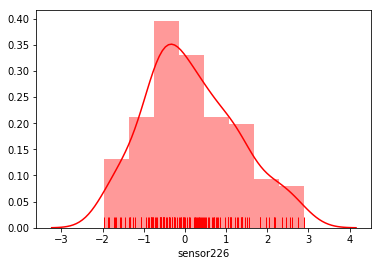

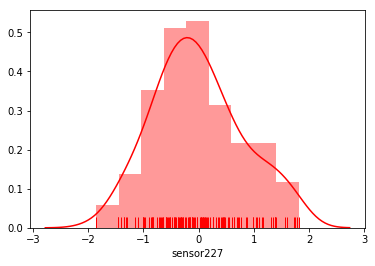

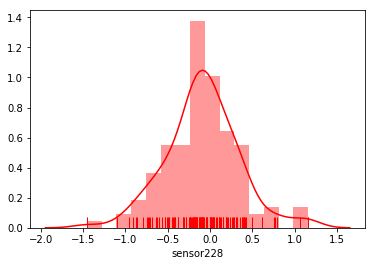

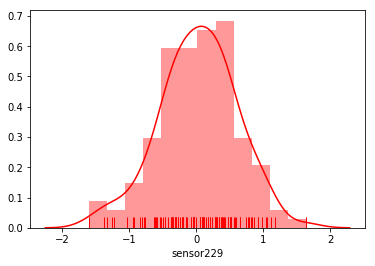

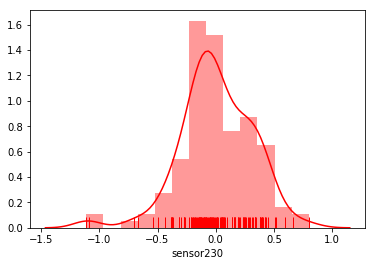

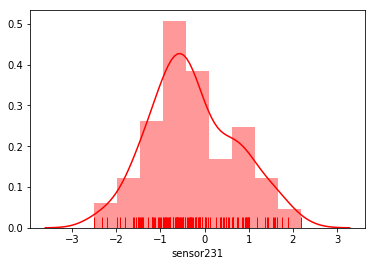

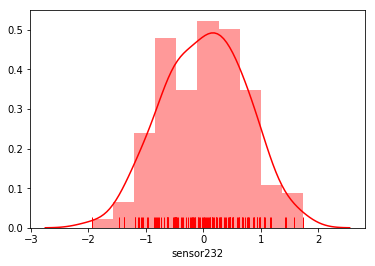

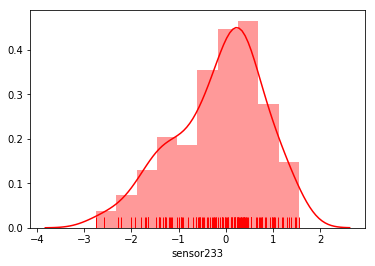

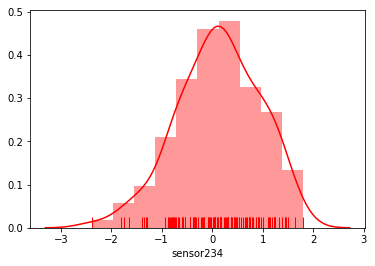

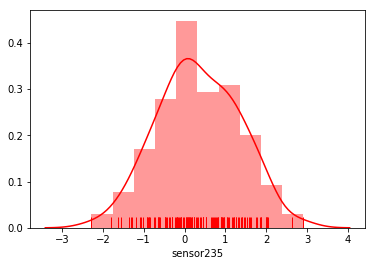

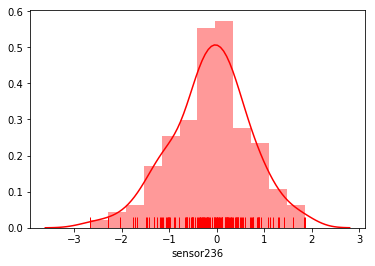

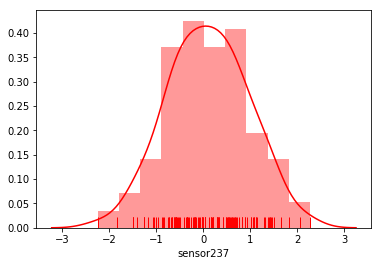

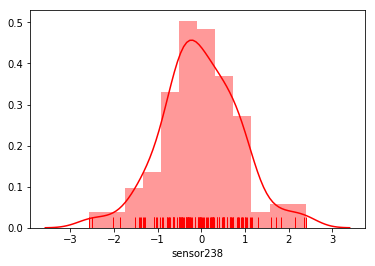

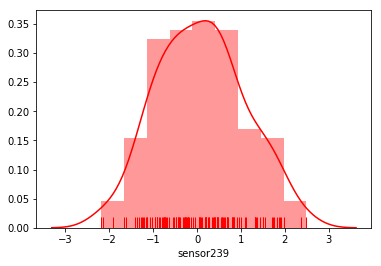

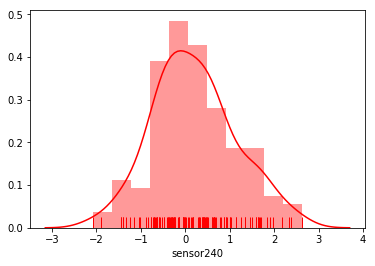

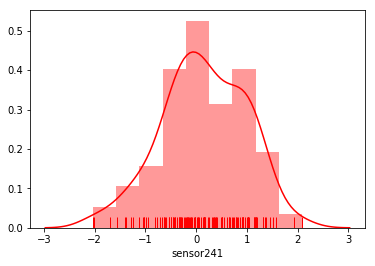

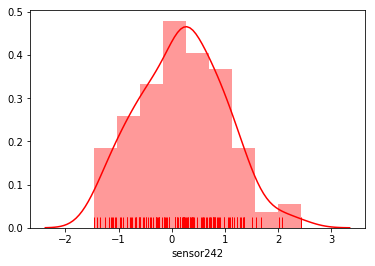

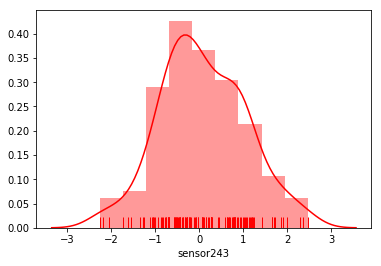

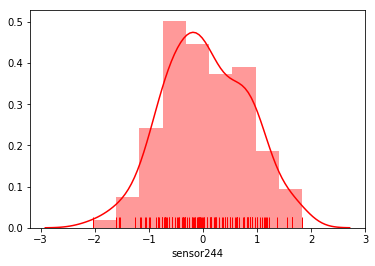

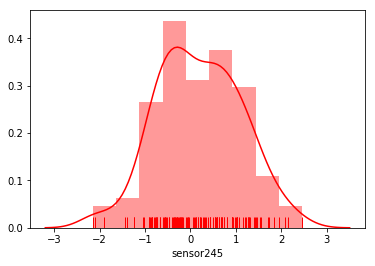

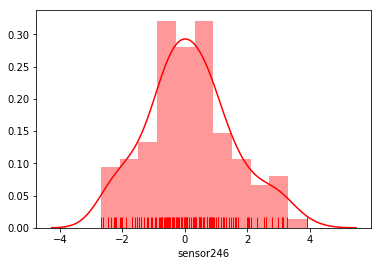

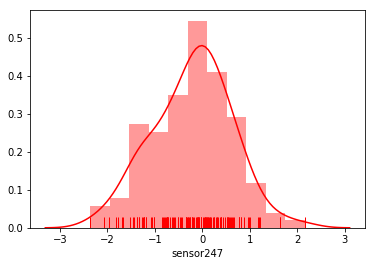

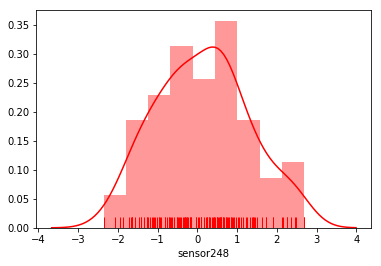

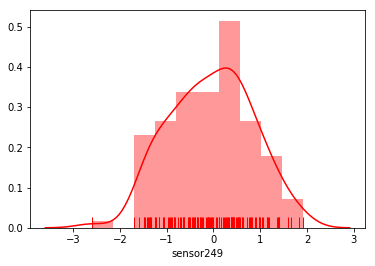

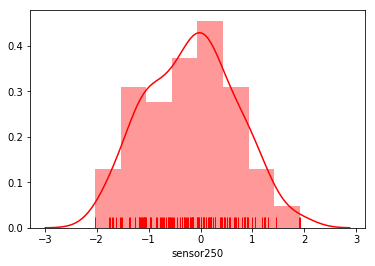

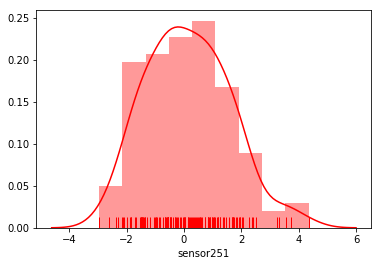

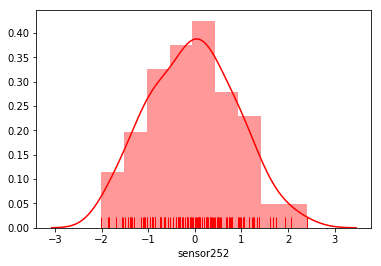

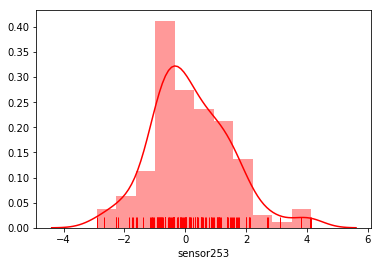

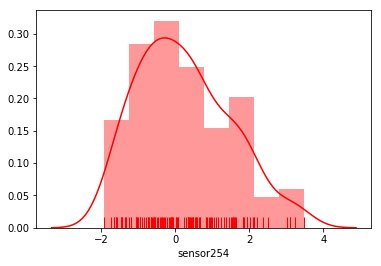

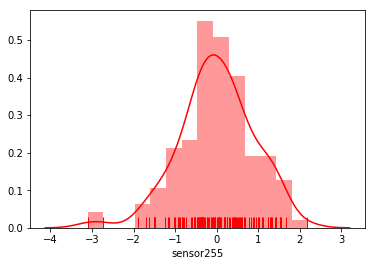

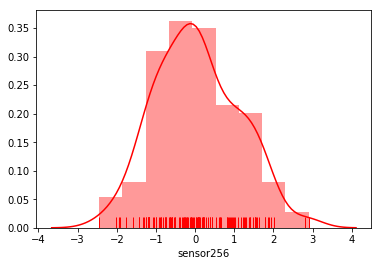

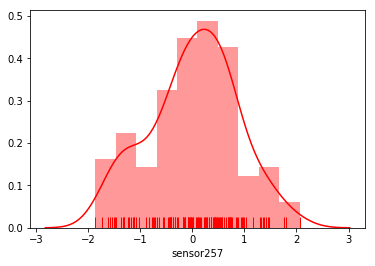

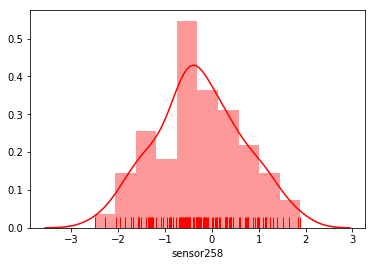

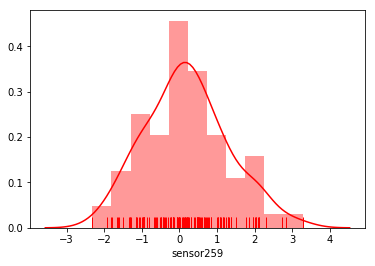

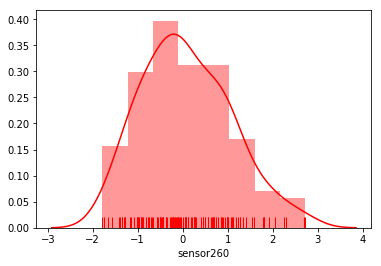

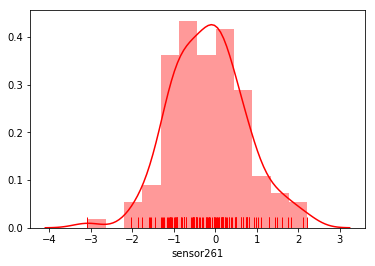

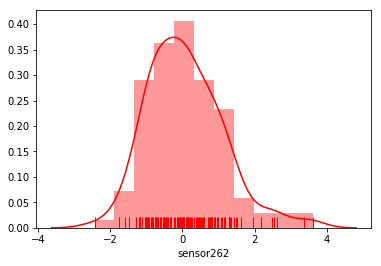

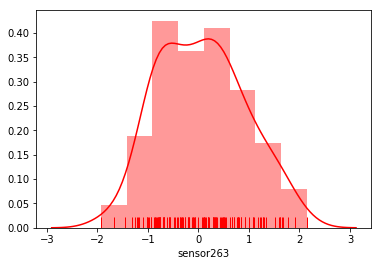

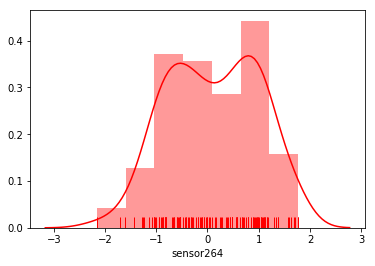

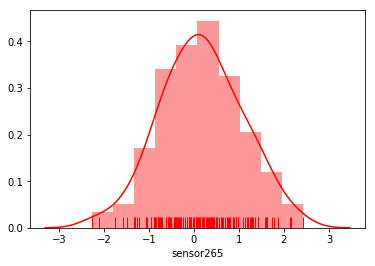

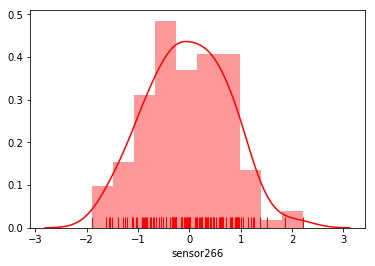

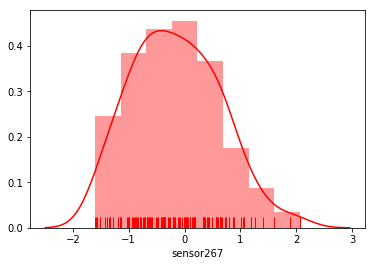

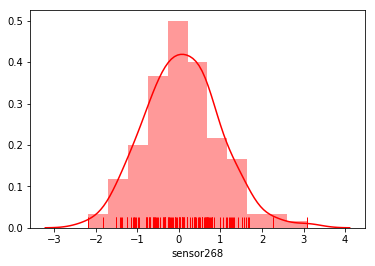

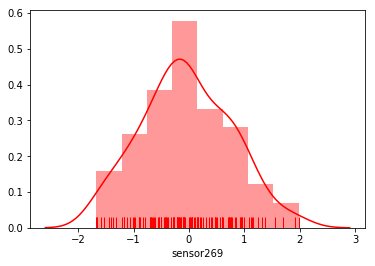

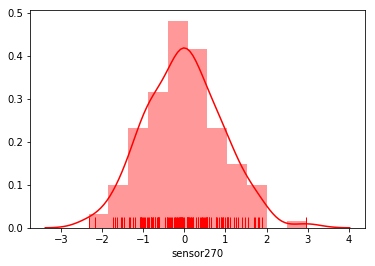

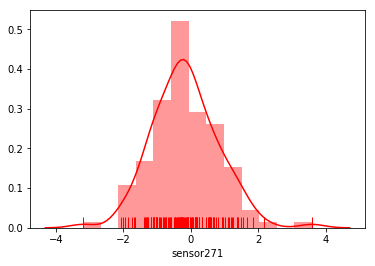

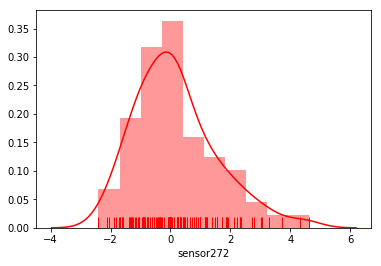

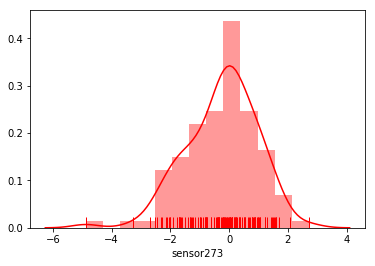

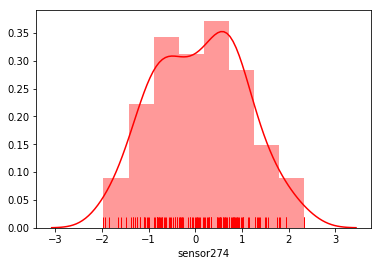

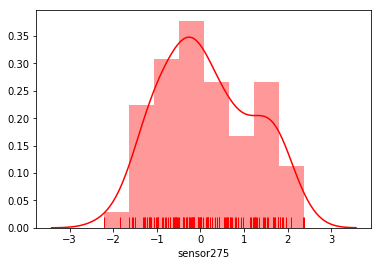

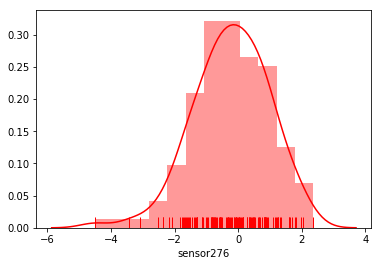

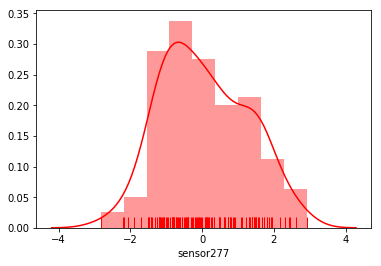

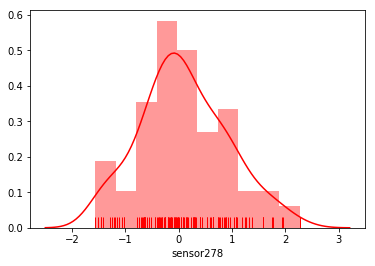

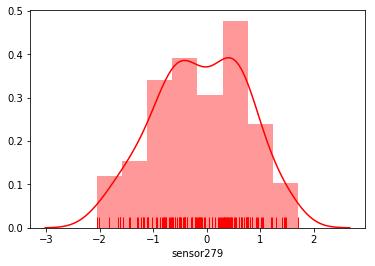

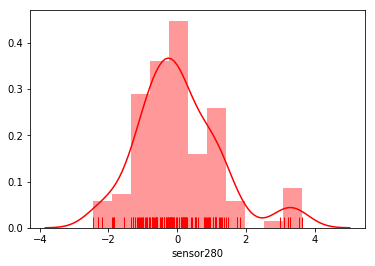

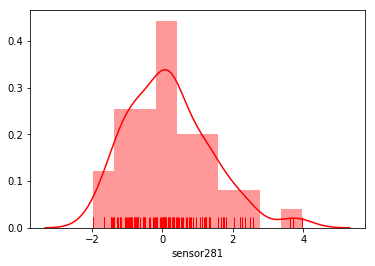

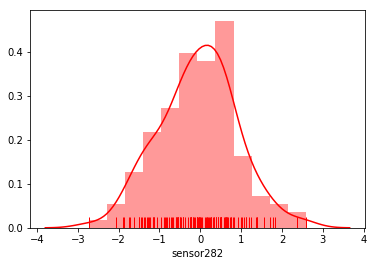

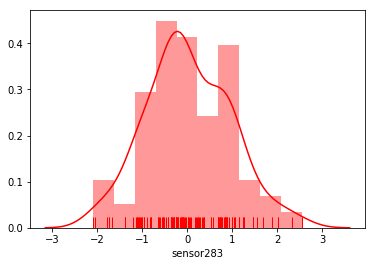

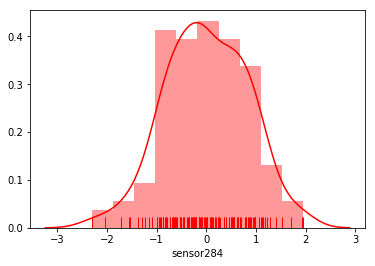

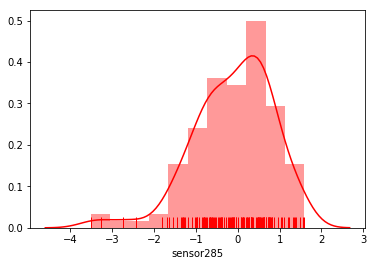

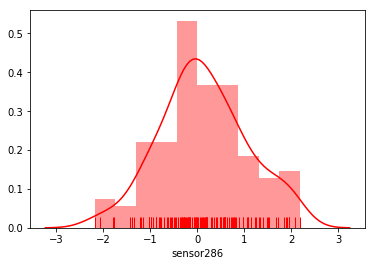

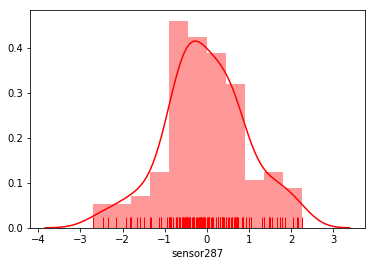

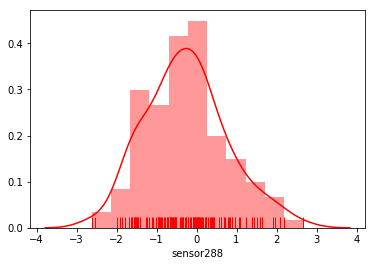

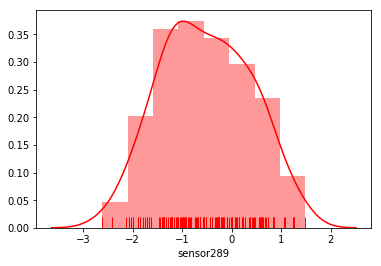

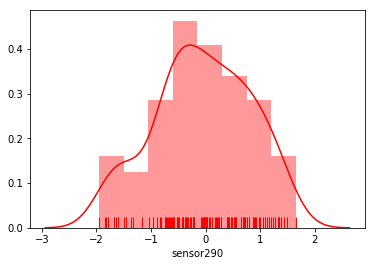

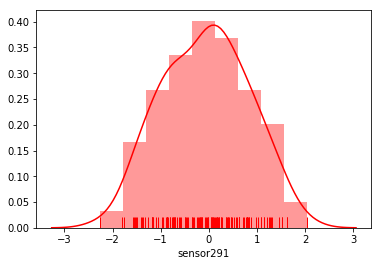

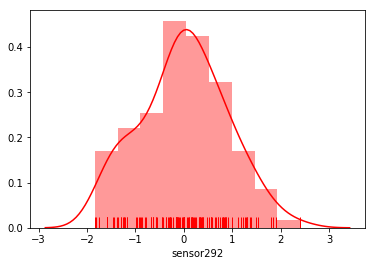

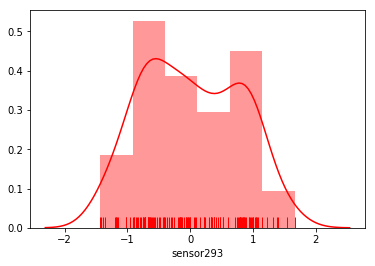

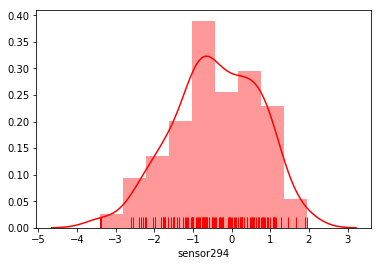

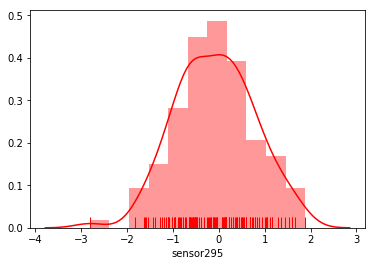

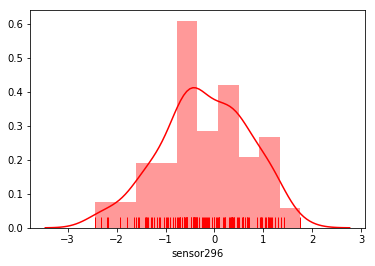

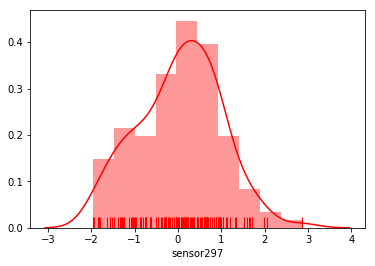

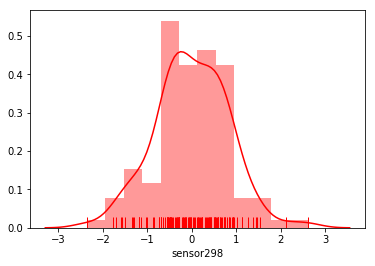

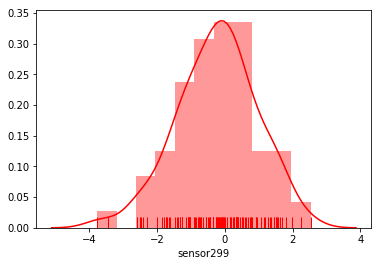

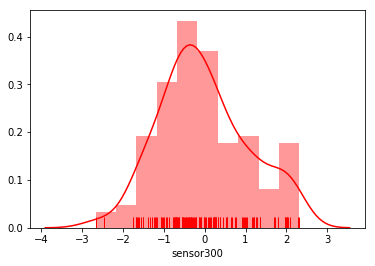

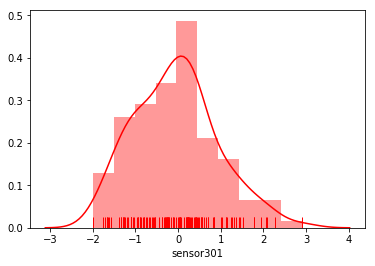

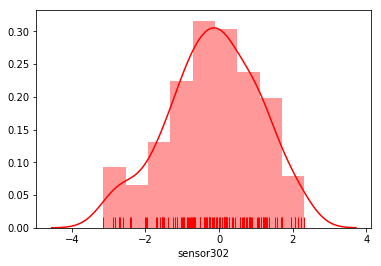

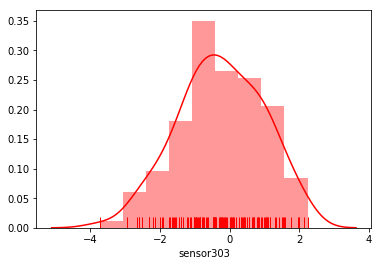

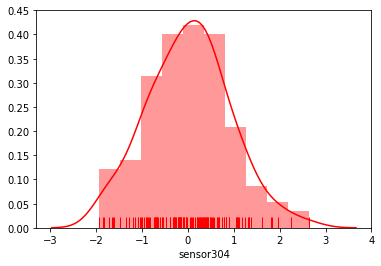

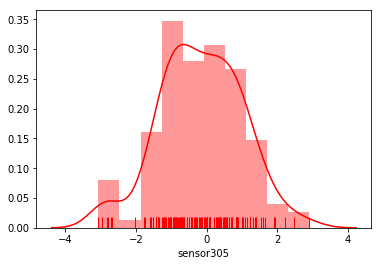

In [0]:
for i in range(0, 306):
    nameSensor = "sensor%s" % i
    sns.distplot(df_sensores[nameSensor], hist=True, rug=True, color="r")
    plt.show()



### Separación de archivos train/test

In [5]:
X_train_new, X_test, y_train_new, y_test = train_test_split(X_train,y_train,test_size=0.2)
print("X_train_new: ",X_train_new.shape)
print("y_train_new: ",y_train_new.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)
print(y_test)

X_train_new:  (7531, 126, 31)
y_train_new:  (7531,)
X_test:  (1883, 126, 31)
y_test:  (1883,)
[1 1 1 ... 1 0 1]


In [0]:
print(len(X_train_new[0,:]))
print(len(X_train_new[0,0,:]))

126
31


### Red LSTM

#### Creación de la red

In [6]:
# Creación de la red
model = Sequential()
model.add(LSTM(3, input_shape=(len(X_train_new[0,:]), len(X_train_new[0,0,:]))))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compilación de la red
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenamiento de la red
model.fit(X_train_new,y_train_new, validation_data=(X_test,y_test), epochs=7, batch_size=10)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3)                 420       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 424
Trainable params: 424
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 7531 samples, validate on 1883 samples
Epoch 1/7
7531/7531 [==============================] - 43s 6ms/step - loss: 0.6956 - acc: 0.5084 - val_loss: 0.6923 - val_acc: 0.5119
Epoch 2/7
7531/7531 [==============================] - 43s 6ms/step - loss: 0.6909 - acc: 0.5217 - val_loss: 0.6903 - val_acc: 0.5258
Epoch 3/7
7531/7531 [==============================] - 43s 6ms/step - loss: 0.6881 - acc: 0.5357 - val_l

#### Predicciones

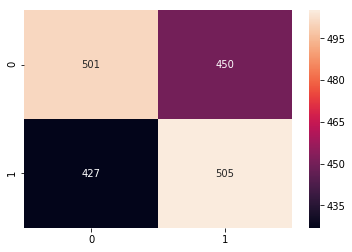

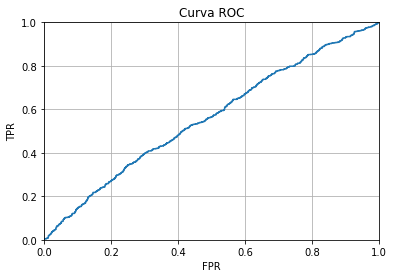

In [7]:
def convert(x):
    result = []
    for i in range(len(x)):
        if x[i] < 0.5:
            result.append(0)
        else:
            result.append(1)
    return result
# Predecimos a partir de los datos de test
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_pred = convert(y_pred)
#print(y_proba)

fprs,tprs,thresholds = metrics.roc_curve(y_test,y_proba)

# Evaluación
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True, fmt="d")
plt.show()

plt.plot(fprs, tprs)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()

### Correlacion entre sensores

#### Creación del dataframe de correlación y gráfica de mapa de colores

Número de sensores:  306


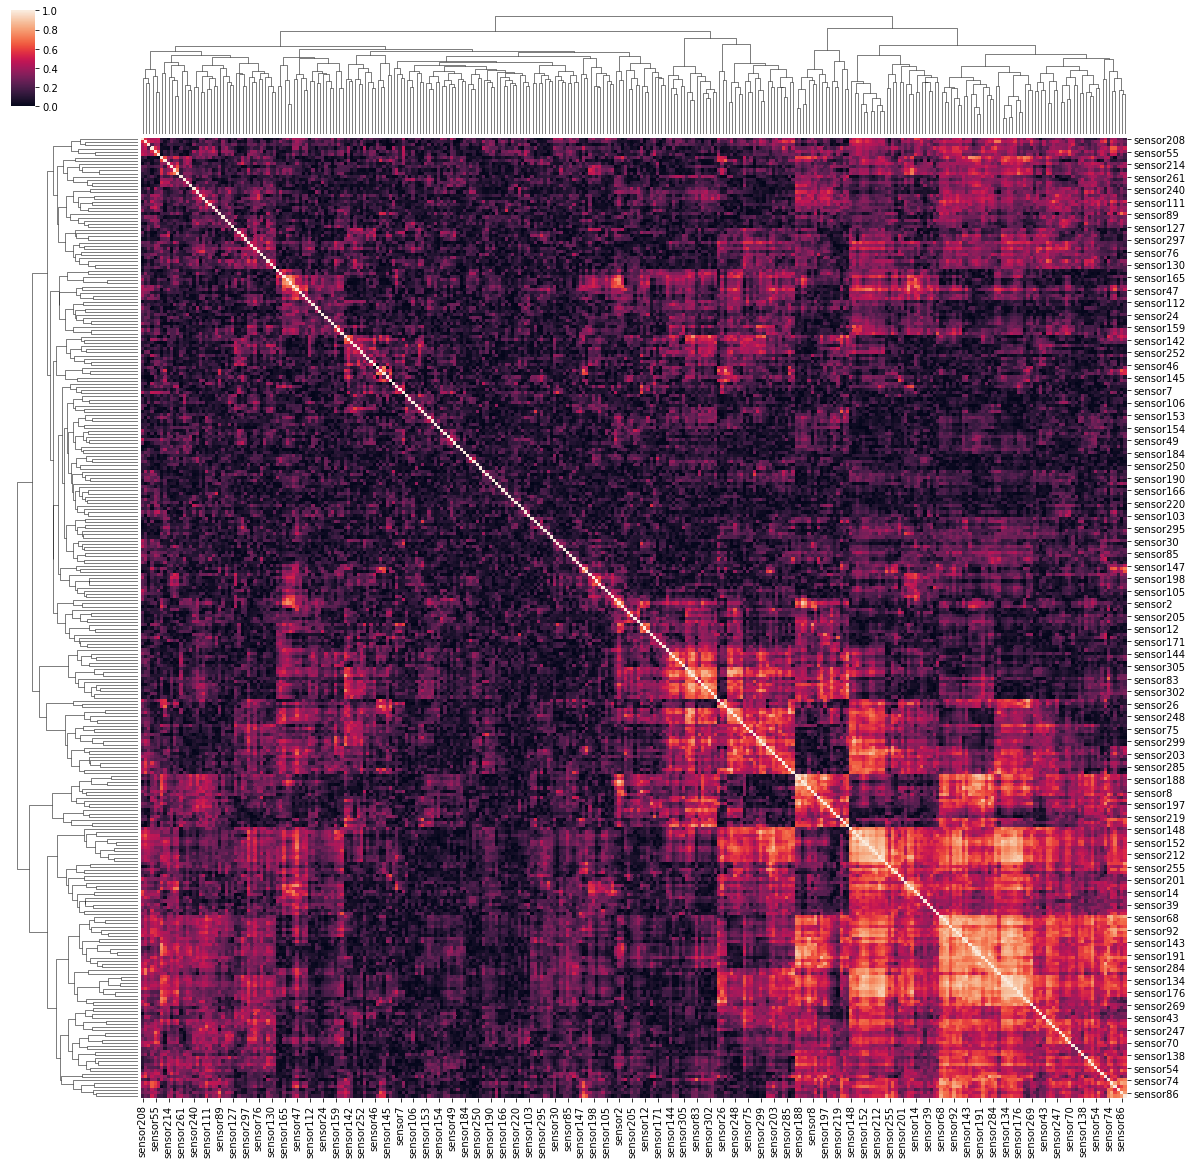

In [0]:
dataframe_sensores = pd.DataFrame()
#num_sensores = int(len(X_train[0,:])/375)
num_sensores = len(X_train[0,:])
print("Número de sensores: ",num_sensores)
columns = []

# Coge el datagrame para X_train 2D
#for i in range(1,num_sensores+1):
 #   nameSensor = 'sensor%s' % i 
  #  columns.append(nameSensor)
   # dataframe_sensores[nameSensor] = pd.Series(X_train[0,(i-1)*375:i*375])
#print(dataframe_sensores)

# Coge el datagrame para X_train 3D
for i in range(0,num_sensores):
    nameSensor = 'sensor%s' % i 
    dataframe_sensores[nameSensor] = pd.Series(X_train[0,i,:])
    
correlaciones = dataframe_sensores.corr()

#sns.heatmap(correlaciones.abs())

sns.clustermap(correlaciones.abs(),figsize=(20, 20))

#### Lista de correlaciones más altas

In [0]:
print(correlaciones)

            sensor0   sensor1   sensor2   sensor3   sensor4   sensor5  \
sensor0    1.000000  0.245252  0.472955  0.460081 -0.101364 -0.060549   
sensor1    0.245252  1.000000  0.185547  0.172177  0.167236 -0.034903   
sensor2    0.472955  0.185547  1.000000  0.625333  0.093149  0.704683   
sensor3    0.460081  0.172177  0.625333  1.000000 -0.218046  0.198398   
sensor4   -0.101364  0.167236  0.093149 -0.218046  1.000000  0.122213   
sensor5   -0.060549 -0.034903  0.704683  0.198398  0.122213  1.000000   
sensor6    0.408282  0.141292  0.624418  0.743435 -0.207594  0.268826   
sensor7    0.216884  0.195277  0.053714  0.119128  0.175206 -0.291641   
sensor8    0.056430  0.151569  0.689541  0.204741  0.347508  0.776770   
sensor9    0.667626  0.197501  0.584324  0.412363 -0.075917  0.210520   
sensor10   0.189021  0.328962 -0.010920  0.141707  0.008242 -0.228518   
sensor11   0.438174  0.249034  0.879920  0.574698  0.182234  0.580633   
sensor12  -0.090905  0.029604  0.379118  0.194287  

In [0]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, umbral=0.5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    n = len(au_corr)
    result = au_corr[0:n].where(au_corr[0:n] > umbral).dropna()
    return result

print("Top Absolute correlaciones de sensores")
print(get_top_abs_correlations(dataframe_sensores,1000,0.7))

Top Absolute correlaciones de sensores
sensor98   sensor128    0.966994
sensor152  sensor161    0.964483
sensor131  sensor134    0.964109
sensor167  sensor191    0.961497
sensor155  sensor158    0.953495
sensor170  sensor173    0.952600
sensor98   sensor134    0.950200
sensor176  sensor185    0.948761
sensor170  sensor188    0.948549
sensor128  sensor134    0.947363
           sensor131    0.946438
sensor179  sensor182    0.946035
sensor11   sensor173    0.938661
sensor155  sensor161    0.937880
sensor182  sensor212    0.934490
sensor185  sensor221    0.933852
sensor164  sensor167    0.932578
sensor200  sensor209    0.929797
sensor92   sensor95     0.929392
sensor140  sensor143    0.927923
sensor191  sensor194    0.926378
sensor95   sensor128    0.926137
sensor182  sensor221    0.924728
sensor131  sensor143    0.923912
sensor182  sensor185    0.922027
sensor98   sensor101    0.921773
sensor62   sensor95     0.920661
sensor131  sensor152    0.919947
sensor182  sensor209    0.919290
sens